# E-Commerce Business Case

In [1]:
# import required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import squarify # for treemap
from datetime import date
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from silhouette import silhoutte_analysis

sns.set_theme(style="darkgrid")

## 1. Load Dataset

In [2]:
# Customers dataframe
df_cust = pd.read_csv('dataset/customers_dataset.csv')

# Orders dataframe
df_order = pd.read_csv('dataset/orders_dataset.csv')

# Order items dataframe
df_item = pd.read_csv('dataset/order_items_dataset.csv')

# Products dataframe
df_prod = pd.read_csv('dataset/products_dataset.csv')

# Product categories dataframe
df_cat = pd.read_csv('dataset/product_category_name_translation.csv')

### 1.1 Customer data

- `customer_id` (text, primary key): key to the orders dataset. Each order has a unique customer_id.
- `customer_unique_id` (text): customer unique identifier
- `customer_zip_code_prefix` (integer): first 5 digits of customer's zip code
- `customer_city` (text): customer's city
- `customer_state` (text): customer's state

In [3]:
# check number of missing values 
print(df_cust.shape)
df_cust.isna().sum()

(99441, 5)


customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

There is no missing value in the customers dataset

In [4]:
# drop unused columns
df_cust = df_cust.drop(columns=['customer_zip_code_prefix'])

# capitalize the first letter of each word in city names
df_cust['customer_city'] = df_cust['customer_city'].str.title()

# customer dataset summary
df_cust.describe().transpose()

,count,unique,top,freq
customer_id,99441,99441,b730b5bb73f94addc7bb956258e7b422,1
customer_unique_id,99441,96096,8d50f5eadf50201ccdcedfb9e2ac8455,17
customer_city,99441,4119,Sao Paulo,15540
customer_state,99441,27,SP,41746


In [5]:
n_customer = df_cust['customer_unique_id'].nunique()
print('Number of unique customers: {}'.format(n_customer))

n_city = df_cust['customer_city'].nunique()
print('Number of unique cities: {}'.format(n_city))

n_state = df_cust['customer_state'].nunique()
print('Number of unique states: {}'.format(n_state))

Number of unique customers: 96096
Number of unique cities: 4119
Number of unique states: 27


- Distribution of the top 10 customers' city:

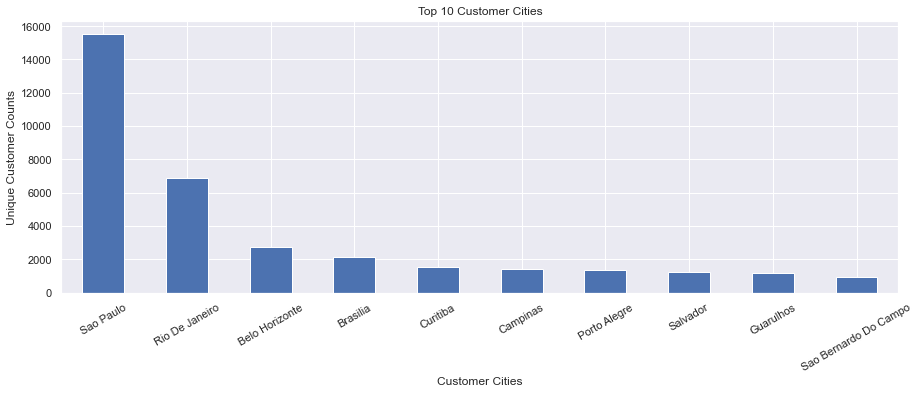

In [6]:
(df_cust.groupby(['customer_city'])['customer_unique_id'].count()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='bar', rot=30, figsize=(15, 5))
)

plt.title('Top 10 Customer Cities')
plt.xlabel('Customer Cities')
plt.ylabel('Unique Customer Counts');

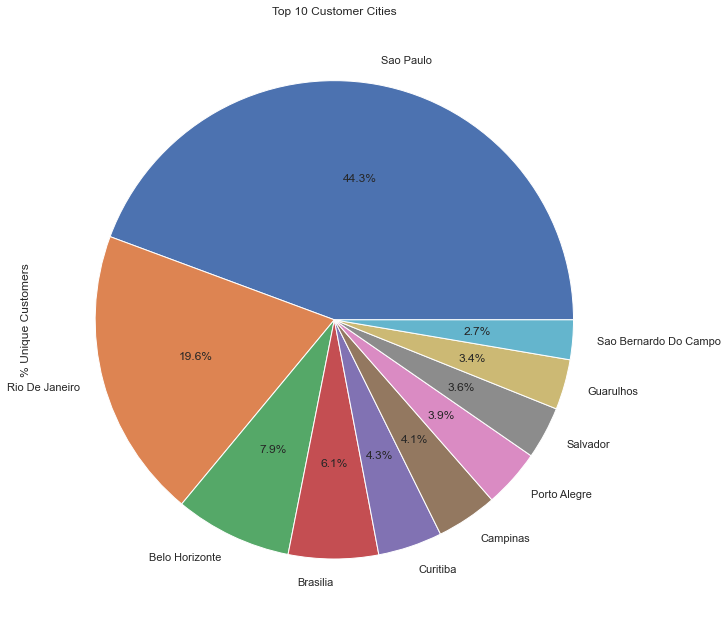

In [7]:
(df_cust.groupby(['customer_city'])['customer_unique_id'].count()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='pie', autopct='%1.1f%%', figsize=(11, 11))
)

plt.title('Top 10 Customer Cities')
plt.ylabel('% Unique Customers');

- Distribution of the top 10 customers' state:

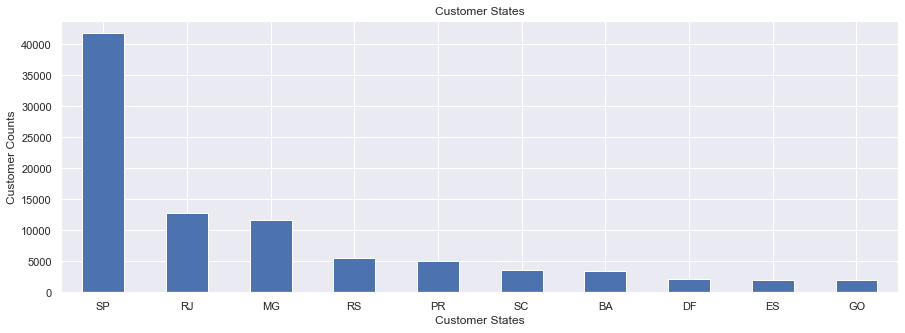

In [8]:
(df_cust.groupby(['customer_state'])['customer_unique_id'].count()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='bar', rot=0, figsize=(15, 5))
)

plt.title('Customer States')
plt.xlabel('Customer States')
plt.ylabel('Customer Counts');

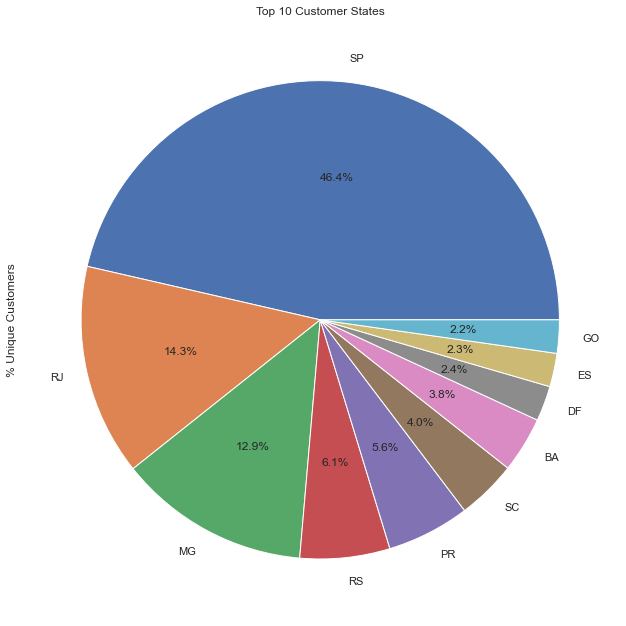

In [9]:
(df_cust.groupby(['customer_state'])['customer_unique_id'].count()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='pie', autopct='%1.1f%%', figsize=(11, 11))
)

plt.title('Top 10 Customer States')
plt.ylabel('% Unique Customers');

### 1.2 Order data

- `order_id` (text): unique identifier of the order
- `customer_id` (text, primary key): key to the customer dataset, each order has a unique customer_id
- `order_status` (text): order status (delivered, shipped, etc)
- `order_purchase_timestamp` (text): the purchase timestamp
- `order_approved_at` (text): the payment approval timestamp
- `order_delivered_carrier_date` (text): the order posting timestamp when it was handled to the logistic partner
- `order_delivered_customer_date` (text): the actual order delivery date to the customer
- `order_estimated_delivery_date` (text): the estimated delivery date that was informed to customer at the time of purchase


In [10]:
# check number of missing values 
print(df_order.shape)
df_order.isna().sum()

(99441, 8)


order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

- There are 1,783 missing order posting dates (1.8%), and 2,965 missing delivery to customer dates (~3%).
- The order purchase date, delivery date and estimated delivery date are important, and the dates will be split into date format and time format.

In [11]:
# drop unused columns
df_order = df_order.drop(columns=['order_approved_at'])

# order dataset summary
df_order.describe(datetime_is_numeric=False).transpose()

,count,unique,top,freq
order_id,99441,99441,f6062f2fd7a79226266b4cdaded643ec,1
customer_id,99441,99441,b730b5bb73f94addc7bb956258e7b422,1
order_status,99441,8,delivered,96478
order_purchase_timestamp,99441,98875,2018-06-01 13:39:44,3
order_delivered_carrier_date,97658,81018,2018-05-09 15:48:00,47
order_delivered_customer_date,96476,95664,2018-05-08 23:38:46,3
order_estimated_delivery_date,99441,459,2017-12-20 00:00:00,522


In [12]:
# function for datetime to date conversion 
def date_conversion(dat, cols):
    for col in cols:
        dat[col] = pd.to_datetime(dat[col], format='%Y-%m-%d').dt.date

In [13]:
# get purchase and delivery time
df_order['purchase_time'] = pd.to_datetime(df_order['order_purchase_timestamp']).dt.time
df_order['delivery_time'] = pd.to_datetime(df_order['order_delivered_carrier_date']).dt.time

# convert date columns into date format
date_conversion(df_order, ['order_purchase_timestamp', 
                           'order_delivered_carrier_date', 
                           'order_delivered_customer_date', 
                           'order_estimated_delivery_date'])

df_order = df_order.rename({'order_purchase_timestamp': 'order_purchase_date'}, axis=1)

# get month/year from purchase date
df_order['purchase_month_year'] = df_order["order_purchase_date"].apply(lambda x: x.strftime('%Y-%m'))

# sort orders by purchase date and time in ascending order
df_order = df_order.sort_values(by = ['order_purchase_date', 'purchase_time'], 
                                ascending = [True, True]).reset_index(drop=True)

Create 3 date values related to delivery dates:

- `Delivery delta`: number of days difference between estimated and actual delivery date (negative delta = actual delivery date was later than the estimated date) 
- `Delivery duration`: number of days difference between order purchase date and the actual delivery date
- `Estimated duration`: number of days difference between order purchase date and the estimated delivery date

In [14]:
df_order['delivery_delta'] = df_order['order_estimated_delivery_date'] - df_order['order_delivered_customer_date']
df_order['delivery_duration'] = df_order['order_delivered_customer_date'] - df_order['order_purchase_date']
df_order['estimated_duration'] = df_order['order_estimated_delivery_date'] - df_order['order_purchase_date']

# convert timedelta to float format
df_order['delivery_delta'] = df_order['delivery_delta'].dt.days
df_order['delivery_duration'] = df_order['delivery_duration'].dt.days
df_order['estimated_duration'] = df_order['estimated_duration'].dt.days

In [15]:
df_order.head(5)

,order_id,customer_id,order_status,order_purchase_date,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_time,delivery_time,purchase_month_year,delivery_delta,delivery_duration,estimated_duration
0,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-18,NaT,2016-10-20,21:15:19,13:14:51,2016-09,NaN,NaN,46
1,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05,NaT,NaT,2016-10-28,00:15:34,NaT,2016-09,NaN,NaN,53
2,809a282bbd5dbcabb6f2f724fca862ec,622e13439d6b5a0b486c435618b2679e,canceled,2016-09-13,NaT,NaT,2016-09-30,15:24:19,NaT,2016-09,NaN,NaN,17
3,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15,2016-11-07,2016-11-09,2016-10-04,12:16:38,17:11:53,2016-09,-36.0,55.0,19
4,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02,NaT,NaT,2016-10-25,22:07:52,NaT,2016-10,NaN,NaN,23


- Distribution of order status:

In [16]:
df_order.groupby(['order_status'])['order_id'].count().sort_values(ascending=False) 

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_id, dtype: int64

The main order status for the missing carrier order posting dates are unavailable, canceled, invoiced, and processing.

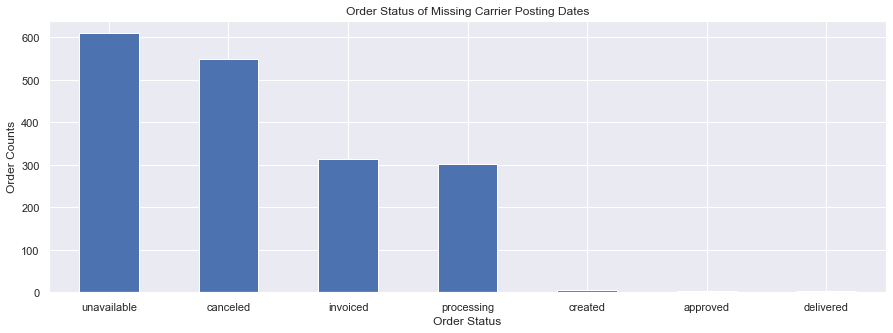

In [17]:
# subset order records where delivered carrier date is N/A
no_carrier_date = df_order[df_order['order_delivered_carrier_date'].isnull()]

(no_carrier_date.groupby(['order_status'])['order_id'].count()
     .sort_values(ascending=False)
     .plot(kind='bar', rot=0, figsize=(15, 5))
)
plt.title('Order Status of Missing Carrier Posting Dates')
plt.xlabel('Order Status')
plt.ylabel('Order Counts');

The main order status for the missing delivery to customer dates are shipped, canceled, unavailable, invoiced, and processing. Note there are 8 delivered orders that were missing the delivery dates.

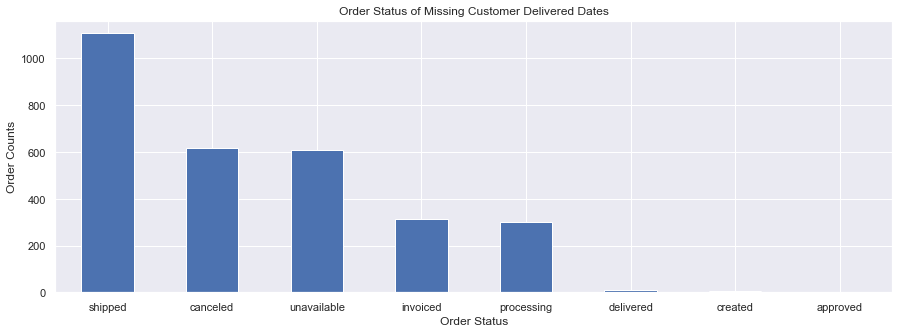

In [18]:
# subset order records where delivered to customer date is N/A
no_delivered_date = df_order[df_order['order_delivered_customer_date'].isnull()]

(no_delivered_date.groupby(['order_status'])['order_id'].count()
     .sort_values(ascending=False)
     .plot(kind='bar', rot=0, figsize=(15, 5))
)
plt.title('Order Status of Missing Customer Delivered Dates')
plt.xlabel('Order Status')
plt.ylabel('Order Counts');

What are the distribution of the delivery delta?
- The most frequent orders (18.5%) were delivered to the customers by 13 to 15 days earlier than the estimated delivery dates.
- There were 6,535 orders (6.57%) with negative delta, up to 188 days delay. Note: Negative delivery delta means that actual delivery date is later than the estimated date.

min   -188.0
max    147.0
Name: delivery_delta, dtype: float64


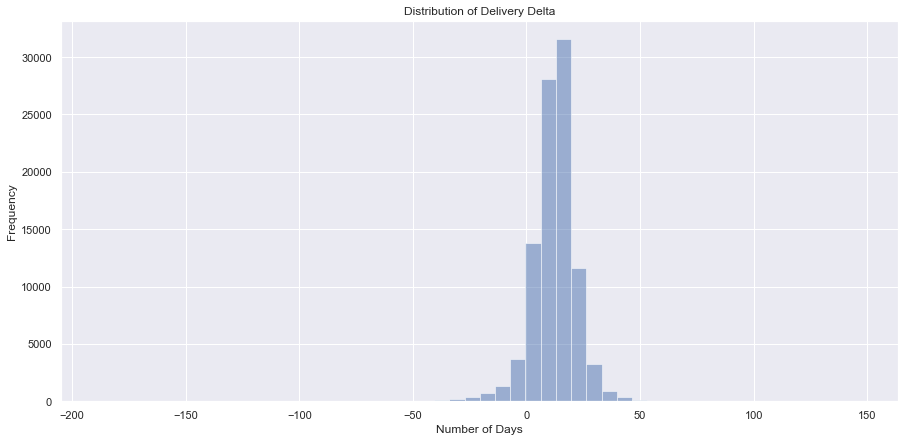

In [19]:
# min and max value of delivery delta
print(df_order['delivery_delta'].agg(['min', 'max']))

# histogram plot
df_order['delivery_delta'].plot.hist(bins=50, alpha=0.5, figsize=(15, 7))
plt.title('Distribution of Delivery Delta')
plt.xlabel('Number of Days');

In [20]:
# number of orders with negative delivery delta
n_negative_delta = df_order[df_order['delivery_delta'] < 0].shape[0]
# % of orders with negative delivery delta
pct_negative_delta = n_negative_delta/df_order.shape[0] * 100

print('Number of orders with negative delivery delta: {}'.format(n_negative_delta))
print('% orders with negative delivery delta: {:.1f}%'.format(pct_negative_delta))

Number of orders with negative delivery delta: 6535
% orders with negative delivery delta: 6.6%


In [21]:
# 3 most frequent delivery delta values
df_order['delivery_delta'].value_counts().nlargest(3)

14.0    7126
13.0    5963
15.0    5345
Name: delivery_delta, dtype: int64

What are the distribution of the delivery duration?
- The most frequent orders (21.2%) were delivered to the customers within 6 to 8 days after the purchase date.
- There were 4,296 orders (4.32%) with delivery durations that exceeded 30 days, up to 210 days. 

min      0.0
max    210.0
Name: delivery_duration, dtype: float64


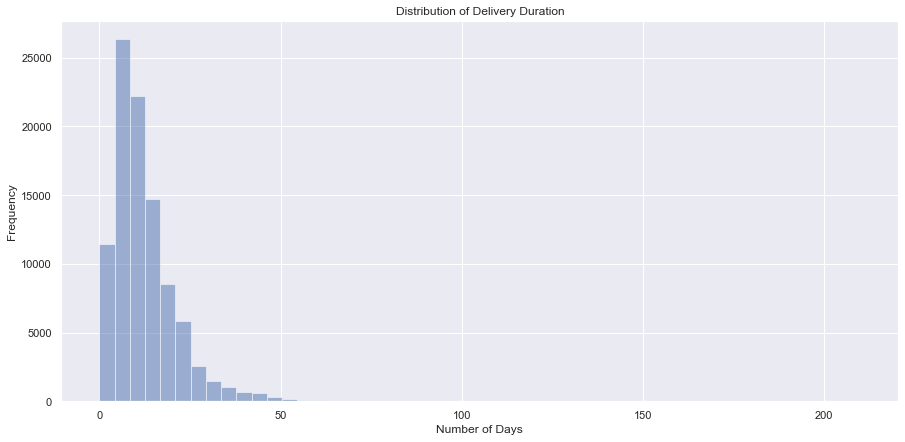

In [22]:
# min and max value of delivery duration
print(df_order['delivery_duration'].agg(['min', 'max']))

# histogram plot
df_order['delivery_duration'].plot.hist(bins=50, alpha=0.5, figsize=(15, 7))
plt.title('Distribution of Delivery Duration')
plt.xlabel('Number of Days');

In [23]:
# number of orders with delivery durations exceeding 30 days
n_long_duration = df_order[df_order['delivery_duration'] > 30].shape[0]
# % of orders with long delivery durations
pct_long_duration = n_long_duration/df_order.shape[0] * 100

print('Number of orders with delivery duration > 30 days: {}'.format(n_long_duration))
print('% orders with delivery duration > 30 days: {}'.format(pct_long_duration))

Number of orders with delivery duration > 30 days: 4296
% orders with delivery duration > 30 days: 4.320149636467855


In [24]:
# 3 most frequent delivery duration values
df_order['delivery_duration'].value_counts().nlargest(3)

7.0    7482
8.0    7123
6.0    6507
Name: delivery_duration, dtype: int64

### 1.3 Order items data

- `order_id` (text): product unique identifier
- `order_item_id` (int): sequential number identifying number of items included in the same order
- `product_id` (text): product unique identifier
- `seller_id` (text): seller unique identifier
- `shipping_limit_date` (text): the seller shipping limit date for handling the order over to the logistic partner
- `price` (float): item price
- `freight_value` (float): item freight value item (the freight value is splitted between items if an order has more than one item)


In [25]:
# check number of missing values 
print(df_item.shape)
df_item.isna().sum()

(112650, 7)


order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [26]:
# order items dataset summary
df_item.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
order_item_id,112650.0,1.197834,0.705124,1.00,1.00,1.00,1.00,21.00
price,112650.0,120.653739,183.633928,0.85,39.90,74.99,134.90,6735.00
freight_value,112650.0,19.990320,15.806405,0.00,13.08,16.26,21.15,409.68


In [27]:
n_orderid = df_item['order_id'].nunique()
print('Number of unique order IDs in Order Items table: {}'.format(n_orderid))

n_order = df_order['order_id'].nunique()
print('Number of unique order IDs in Orders table: {}'.format(n_order))

n_itemid = df_item['order_item_id'].nunique()
print('Number of unique order item IDs: {}'.format(n_itemid))

n_prodid = df_item['product_id'].nunique()
print('Number of unique product IDs: {}'.format(n_prodid))

n_sellerid = df_item['seller_id'].nunique()
print('Number of unique seller IDs: {}'.format(n_sellerid))

Number of unique order IDs in Order Items table: 98666
Number of unique order IDs in Orders table: 99441
Number of unique order item IDs: 21
Number of unique product IDs: 32951
Number of unique seller IDs: 3095


There are 775 orders that were not in the Order Items table. 603 orders were marked as unavailable, and 164 orders were marked as canceled. I assume that the E-Commerce platform does not execute customers' order for either status.

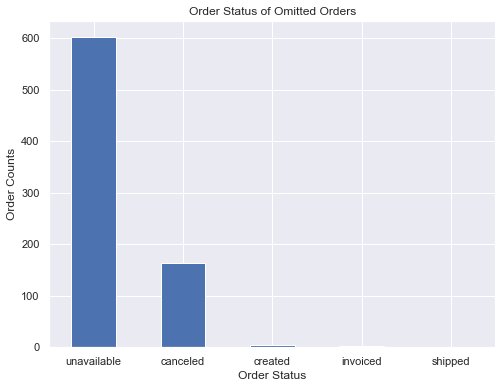

In [28]:
# select all order_ids from order table that are not in orders_items
omitted_orders = df_order[~df_order['order_id'].isin(df_item['order_id'])]

(omitted_orders.groupby(['order_status'])['order_id'].count()
     .sort_values(ascending=False)
     .plot(kind='bar', rot=0, figsize=(8, 6))
)
plt.title('Order Status of Omitted Orders')
plt.xlabel('Order Status')
plt.ylabel('Order Counts');

The Order Items table **does not have an item quantity column** because each order with multiple items is broken down sequentially into multiple order lines via the `order_item_id` ie. if an order is consisted of 5 items that are the same, it will have 5 order item records with `order_item_id` from 1 to 5, and duplicated order ids and product ids. Hence, I will consolidate these records with duplicated order ids and product ids into an item quantity column.

I assume that the items with same product ID are sold by the same seller, with the same price, freight value and shipping limit date.

In [29]:
# check order item records with duplicate order id and product id
print('Number of duplicated order ids and product ids: {}'
    .format(df_item[['order_id', 'product_id']].duplicated().sum()))

Number of duplicated order ids and product ids: 10225


In [30]:
# consolidate order item records with same order id and product id
df_item_simplified = df_item.groupby(by=['order_id', 'product_id'], as_index=False)\
    .agg({'order_item_id': 'count', 
          'seller_id': 'first',
          'shipping_limit_date': 'first',
          'price': 'first',
          'freight_value': 'first'})

# rename order item id into order item quantity
df_item_simplified = df_item_simplified.rename({'order_item_id': 'item_qty'}, axis=1)

In [31]:
df_item_simplified.head(5)

,order_id,product_id,item_qty,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,1,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,1,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,1,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,1,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,1,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Verify that data is retained in the consolidated Order Items table:

In [32]:
orderid_old = df_item['order_id'].nunique()
print('Unique order IDs in original Order Items table: {}'.format(orderid_old))
orderid_new = df_item_simplified['order_id'].nunique()
print('Unique order IDs in consolidated Order Items table: {}'.format(orderid_new))
print(' ')

productid_old = df_item['product_id'].nunique()
print('Unique product IDs in original Order Items table: {}'.format(productid_old))
productid_new = df_item_simplified['product_id'].nunique()
print('Unique product IDs in consolidated Order Items table: {}'.format(productid_new))
print(' ')

item_qty_old = len(df_item)
print('Item quantities in original Order Items table: {}'.format(item_qty_old))
item_qty_new = df_item_simplified['item_qty'].sum()
print('Item quantities in consolidated Order Items table: {}'.format(item_qty_new))
print(' ')

Unique order IDs in original Order Items table: 98666
Unique order IDs in consolidated Order Items table: 98666
 
Unique product IDs in original Order Items table: 32951
Unique product IDs in consolidated Order Items table: 32951
 
Item quantities in original Order Items table: 112650
Item quantities in consolidated Order Items table: 112650
 


What are the distribution of order item quantities:
- On average, buyers purchase 1 unit of the same item in the same order
- There were 7088 orders (6.9%) where the buyers purchase multiple units (up to 20) of the same item 

min     1
max    20
Name: item_qty, dtype: int64


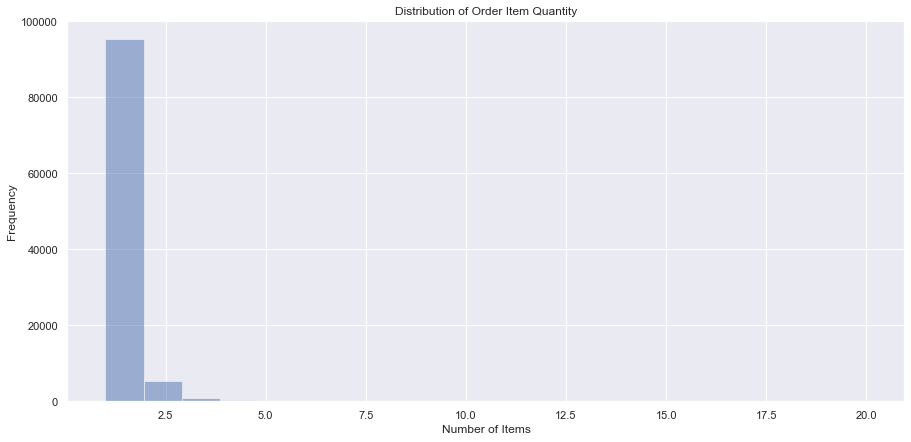

In [33]:
# min and max value of order item quantity
print(df_item_simplified['item_qty'].agg(['min', 'max']))

# histogram plot
df_item_simplified['item_qty'].plot.hist(bins=20, alpha=0.5, figsize=(15, 7))
plt.title('Distribution of Order Item Quantity')
plt.xlabel('Number of Items');

In [34]:
# number of orders with 1 item
qty_1 = df_item_simplified[df_item_simplified['item_qty'] == 1].shape[0]
# % of orders with 1 item
pct_qty_1 = qty_1/df_item_simplified.shape[0] * 100

# number of orders with multiple same items
qty_m = df_item_simplified[df_item_simplified['item_qty'] > 1].shape[0]
# % of orders with multiple same items
pct_qty_m = qty_m/df_item_simplified.shape[0] * 100

# average quantity per order
avg_qty = df_item_simplified['item_qty'].mean() 

print('Number of orders with 1 item: {}'.format(qty_1))
print('% of orders with 1 item: {:.1f}%'.format(pct_qty_1))

print('Number of orders with multiple same items: {}'.format(qty_m))
print('% of orders with multiple same items: {:.1f}%'.format(pct_qty_m))

print('Average quantity of the same item per order: {:.2f}'.format(avg_qty))

Number of orders with 1 item: 95337
% of orders with 1 item: 93.1%
Number of orders with multiple same items: 7088
% of orders with multiple same items: 6.9%
Average quantity of the same item per order: 1.10


### 1.4 Product and Product categories data

- `product_id` (text): unique product identifier
- `product_category_name` (text): root category of product, in Portuguese
- `product_name_lenght` (int): number of characters extracted from the product name
- `product_description_lenght` (int): number of characters extracted from the product description
- `product_photos_qty` (int): number of product published photos
- `product_weight_g` (int): product weight (in grams)
- `product_length_cm` (int): product length (in centimeters)
- `product_height_cm` (int): product height (in centimeters)
- `product_width_cm` (int): product width (in centimeters)


In [35]:
# check number of missing values 
print(df_prod.shape)
df_prod.isna().sum()

(32951, 9)


product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

- `product_category_name` (text): category name in Portuguese
- `product_category_name_english` (text): category name in English

In [36]:
print(df_cat.shape)
df_cat.isna().sum()

(71, 2)


product_category_name            0
product_category_name_english    0
dtype: int64

In [37]:
# left merge products with product category to get english names
df_prod = df_prod.merge(df_cat, on='product_category_name', how='left')

# fill nan in product_category_name with none
df_prod['product_category_name'] = df_prod['product_category_name'].fillna('none')
# fill nan in product_category_name_english with product_category_name
df_prod['product_category_name_english'] = df_prod['product_category_name_english'].fillna(df_prod['product_category_name'])

# get product volume = length * height * width
df_prod['product_volume_cm'] = df_prod['product_length_cm'] * df_prod['product_height_cm'] * df_prod['product_width_cm']

# fill nan in product_photos_qty with 0
df_prod['product_photos_qty'] = df_prod['product_photos_qty'].fillna(0.0)
# convert float to int
df_prod['product_photos_qty'] = df_prod['product_photos_qty'].astype(int)

# drop unused columns
df_prod = df_prod.drop(['product_category_name', 'product_name_lenght', 
                        'product_description_lenght', 'product_length_cm', 
                        'product_height_cm', 'product_width_cm'], axis=1)

In [38]:
# replace underscores in the product category english names with spaces
df_prod['product_category_name_english'] = df_prod['product_category_name_english'].str.replace("_", " ")

# capitalize the first letter of each word in city names
df_prod['product_category_name_english'] = df_prod['product_category_name_english'].str.title()

In [39]:
df_prod.head(5)

,product_id,product_photos_qty,product_weight_g,product_category_name_english,product_volume_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,1,225.0,Perfumery,2240.0
1,3aa071139cb16b67ca9e5dea641aaa2f,1,1000.0,Art,10800.0
2,96bd76ec8810374ed1b65e291975717f,1,154.0,Sports Leisure,2430.0
3,cef67bcfe19066a932b7673e239eb23d,1,371.0,Baby,2704.0
4,9dc1a7de274444849c219cff195d0b71,4,625.0,Housewares,4420.0


## 2. Consolidate Customers, Orders, Order Items and Products tables

In [40]:
# merge order items and products on product_id
df_item_prod = df_item_simplified.merge(df_prod, left_on='product_id', right_on='product_id')

# merge customers and orders on customer_id
df_cust_order = df_cust.merge(df_order, left_on='customer_id', right_on='customer_id')

# consolidate dataframe by merging customers/orders table with 
# order items/products on order_id
df_consolidated = df_cust_order.merge(df_item_prod,left_on='order_id', right_on='order_id')

In [41]:
# transaction price = item qty * price
df_consolidated['trnx_price'] = df_consolidated['item_qty'] * df_consolidated['price']

# transaction freight value = item qty * freight value
df_consolidated['trnx_frieght_value'] = df_consolidated['item_qty'] * df_consolidated['freight_value']

# order weight (g) = item qty * product weight (g)
df_consolidated['order_weight_g'] = df_consolidated['item_qty'] * df_consolidated['product_weight_g']

# order volume (ltr) = item qty * product volume (cm3) / 1000
df_consolidated['order_volume_ltr'] = df_consolidated['item_qty'] * df_consolidated['product_volume_cm'] / 1000


In [42]:
df_consolidated.head(5)

,customer_id,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_date,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,...,price,freight_value,product_photos_qty,product_weight_g,product_category_name_english,product_volume_cm,trnx_price,trnx_frieght_value,order_weight_g,order_volume_ltr
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,Franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16,2017-05-23,2017-05-25,2017-06-05,...,124.99,21.88,1,8683.0,Office Furniture,107136.0,124.99,21.88,8683.0,107.136
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,Sao Bernardo Do Campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12,2018-01-15,2018-01-29,2018-02-06,...,289.00,46.48,3,10150.0,Housewares,53400.0,289.00,46.48,10150.0,53.400
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,Sao Paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19,2018-06-11,2018-06-14,2018-06-13,...,139.94,17.79,1,8267.0,Office Furniture,45968.0,139.94,17.79,8267.0,45.968
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,Mogi Das Cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13,2018-03-27,2018-03-28,2018-04-10,...,149.94,23.36,1,12160.0,Office Furniture,79968.0,149.94,23.36,12160.0,79.968
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,Campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29,2018-07-30,2018-08-09,2018-08-15,...,230.00,22.25,1,5200.0,Home Confort,23625.0,230.00,22.25,5200.0,23.625


In [43]:
# save consolidated data frame as pickle file
#df_consolidated.to_pickle("consolidated.pkl")

## 3. Exploratory Analysis

- Focus on orders where the status is 'delivered' or 'shipped' (~98.9% of the original records).
- There are only 3,186 repeating customers (3.4% of all unique customers).

In [44]:
df_consolidated = df_consolidated[(df_consolidated['order_status'] == 'delivered') | 
                                  (df_consolidated['order_status'] == 'shipped')].reset_index(drop=True)

In [45]:
# how many repeating customers?
rcust = df_consolidated[['customer_id','customer_unique_id','order_id','order_purchase_date']].drop_duplicates().reset_index(drop=True)
rcust = rcust.sort_values(by = ['customer_unique_id', 'order_purchase_date'], ascending = [True, True])

rcust_dup = rcust[rcust['customer_unique_id'].duplicated()]

In [46]:
# number of repeating customers = duplicated customer unique ids in different transaction records
repeat_cust = rcust_dup.shape[0]

# total number of unique customers
total_cust = rcust['customer_unique_id'].nunique()

# % of repeating customers
pct_repeat_cust = repeat_cust/total_cust * 100

print('Number of repeating customers: {}'.format(repeat_cust))
print('Total number of unique customers: {}'.format(total_cust)) 
print('% of repeating customers: {:.1f}%'.format(pct_repeat_cust))

Number of repeating customers: 3186
Total number of unique customers: 94398
% of repeating customers: 3.4%


### 3.1 Sales trend analysis over time

<ul>
    <li><p>The time series charts below show the daily total revenue and number of items ordered by the customers. The last chart shows the average delivery time, estimated delivery duration, and the difference between the estimated and the delivery dates (ie. a positive delivery time delta means that the item arrived at the customers earlier than the estimated date).</p></li>
    <br>
    <li><p>The general trends indicate a steady increase in the total revenue and order volume, from a daily average of R\$4,230 and 34 items in January 2017, to R\$29,178 and 248 items in August 2018. There was a notable peak on Black Friday 2017 (November 24th, 2017), where the E-Commerce platform received orders for 1,359 items and earned R\$151019.95. However, the sales during the Christmas and New Year break (Decemeber 24th 2017, December 25th 2017, December 31st 2017, Janaury 1st 2018) were lower than expected, where the platform earned a daily average of R\$7,778 for 79 items. It appeared that customers who needed to make a purchase tend to finalize their orders in advance before those 2 holidays.</p></li>
    <br>
    <li><p>The average delivery duration per order maintained at approximately 12 days in 2017 and 2018. However, the average delivery duration increased to 17 days during Black Friday 2017, and approximately 15 days through December 2017. Hence, there was a need for logistic planning in anticipation to higher customer demands during the popular festivals.</p></li>
    <br>
    <li><p>There was also a significant uptick in the average estimated shipping duration to 37 days between May 25th 2018 and June 7th 2018. The uptick coincided with the 2018 Brazil truck drivers' strike that took place between May 21st 2018 and early June, and the E-Commerce platform might have overestimated the shipping duration in fear of disruptions caused by the strike. However, there was no measurable impact on the actual delivery durations to the customers.</p></li>
</ul>

In [47]:
# consolidate daily order trends by purchase dates
daily_order = df_consolidated.groupby('order_purchase_date')\
                  .agg({'order_id':'count',
                        'item_qty':'sum',
                        'trnx_price':'sum',
                        'delivery_delta':'mean',
                        'delivery_duration':'mean',
                        'estimated_duration':'mean'}).reset_index()

# rename daily order columns
daily_order = daily_order.rename({'order_id': 'num_order',
                                  'item_qty': 'total_item_qty',
                                  'trnx_price': 'total_revenue',
                                  'delivery_delta': 'avg_delivery_delta',
                                  'delivery_duration': 'avg_delivery_duration',
                                  'estimated_duration': 'avg_estimated_duration'}, axis=1)

# subset the records from January 1st 2017 to Sept 1st 2018
startdate = pd.to_datetime("2017-01-01").date()
enddate = pd.to_datetime("2018-09-01").date()
daily_order = daily_order[(daily_order['order_purchase_date'] >= startdate) & 
                          (daily_order['order_purchase_date'] <= enddate)].reset_index(drop=True)

In [48]:
daily_order.head(5)

,order_purchase_date,num_order,total_item_qty,total_revenue,avg_delivery_delta,avg_delivery_duration,avg_estimated_duration
0,2017-01-05,32,32,396.90,25.00,10.8125,35.812500
1,2017-01-06,4,4,916.38,33.75,7.7500,41.500000
2,2017-01-07,4,5,1351.90,16.75,24.2500,41.000000
3,2017-01-08,6,6,709.58,31.50,8.2500,41.333333
4,2017-01-09,5,6,673.79,14.40,23.6000,38.000000


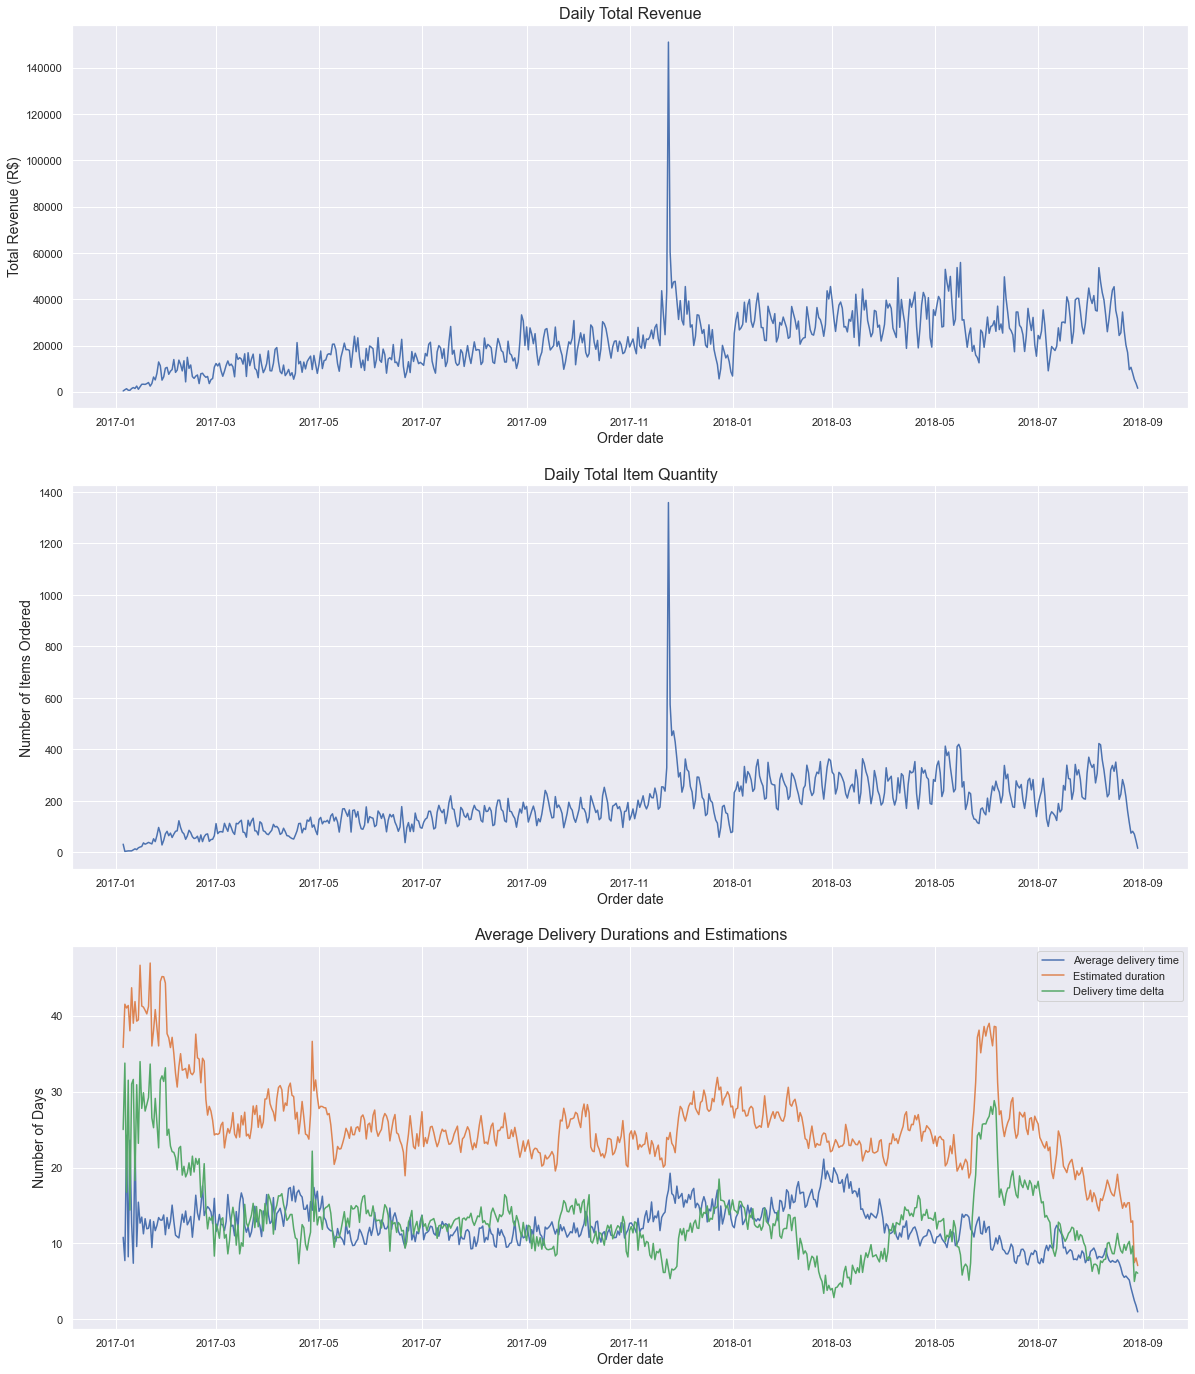

In [49]:
# create line plots for time series trends
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (20, 24))

ax1.set_title('Daily Total Revenue', fontsize=16)
ax2.set_title('Daily Total Item Quantity', fontsize=16)
ax3.set_title('Average Delivery Durations and Estimations', fontsize=16)

sns.lineplot(data = daily_order, x = 'order_purchase_date', y ='total_revenue', ax = ax1)
sns.lineplot(data = daily_order, x = 'order_purchase_date', y ='total_item_qty', ax = ax2)
sns.lineplot(data = daily_order, x = 'order_purchase_date', y ='avg_delivery_duration', ax = ax3)
sns.lineplot(data = daily_order, x = 'order_purchase_date', y ='avg_estimated_duration', ax = ax3)
sns.lineplot(data = daily_order, x = 'order_purchase_date', y ='avg_delivery_delta', ax = ax3)

ax1.set_xlabel('Order date', fontsize = 14)
ax1.set_ylabel('Total Revenue (R$)', fontsize = 14)

ax2.set_xlabel('Order date', fontsize = 14)
ax2.set_ylabel('Number of Items Ordered', fontsize = 14)

ax3.set_xlabel('Order date', fontsize = 14)
ax3.set_ylabel('Number of Days', fontsize = 14)
ax3.legend(['Average delivery time',
            'Estimated duration',
            'Delivery time delta'])

plt.show();

### 3.2 Total Monthly Revenue and Month-over-Month Revenue Growth

<ul>
    <li><p>The monthly revenue was increasing overall, but the revenue growth was also slowing down in 2018 with the E-Commerce platform also experiencing little to negative month-to-month growth.</p></li>
    <br>
    <li><p>The total monthly revenue peaked in November 2017 at R\$995,028, for a 52.2% month-over-month revenue growth, largely due to the boost on Black Friday. That was followed by a 26.4% drop in monthly revenue at R\$732,492 in December 2017, since customers who needed to make a purchase already took advantage of the Black Friday sales.</p></li>
    <br>
    <li><p>The monthly revenues held steady in 2018 between R\$836,448 and R\$990,554. The platform only achieved double digits month-over-month revenue growth in January 2018 and March 2018 at 27.6% and 16.0% respectively.</p></li>
</ul>

In [50]:
# sum total transaction price by customer city
monthly_revenue = df_consolidated.groupby(['purchase_month_year'])['trnx_price'].sum().reset_index()

# filter by purchase_month_year between 2017-01 and 2018-08
monthly_revenue = monthly_revenue[(monthly_revenue['purchase_month_year'] >= '2017-01') & 
                                  (monthly_revenue['purchase_month_year'] <= '2018-08')].reset_index(drop=True)

# rename column
monthly_revenue = monthly_revenue.rename({'trnx_price': 'total_revenue'}, axis=1)

# monthly revenue in R$1000s
monthly_revenue['total_revenue'] = monthly_revenue['total_revenue'] / 1000

# calculate month-over-month % revenue growth
monthly_revenue['pct_revenue_growth'] = monthly_revenue['total_revenue'].pct_change() * 100

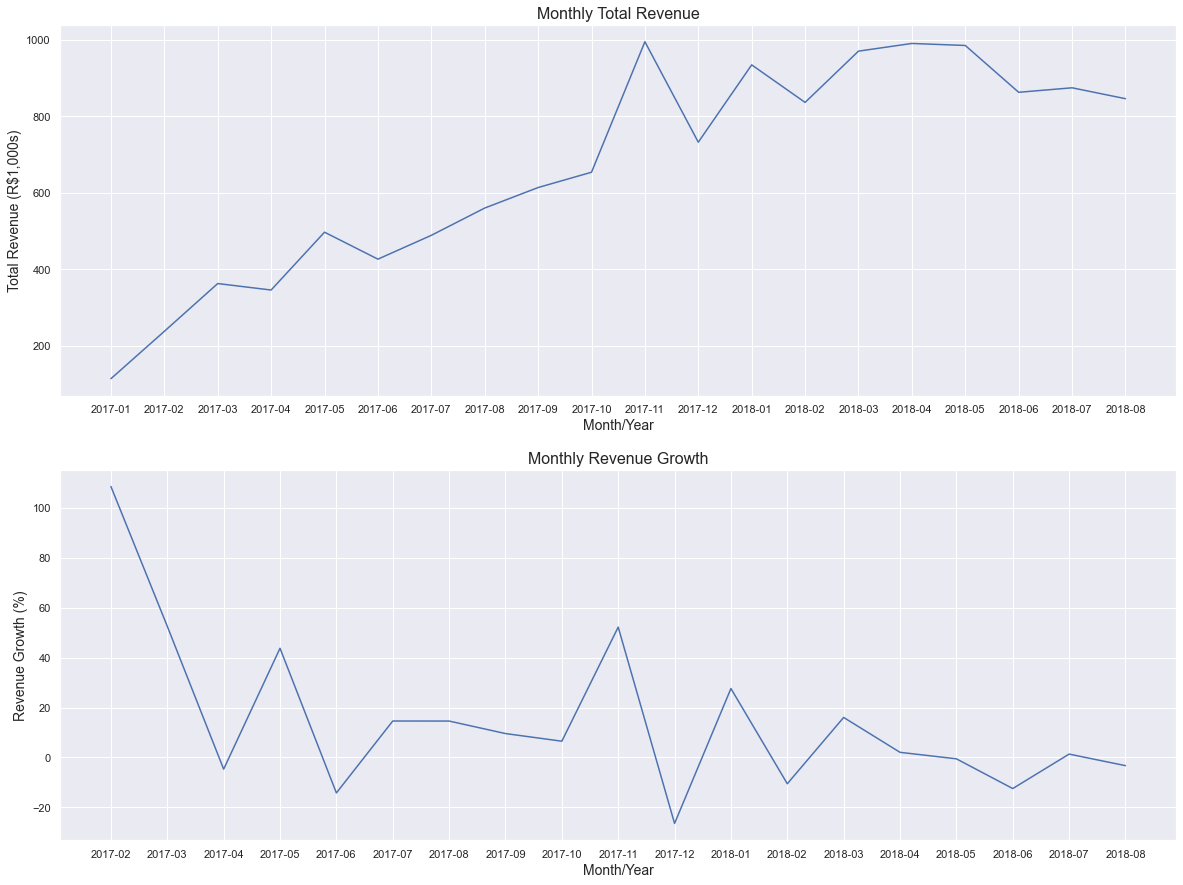

In [51]:
fig, (ax4, ax5) = plt.subplots(2, 1, figsize = (20, 15))

ax4.set_title('Monthly Total Revenue', fontsize=16)
ax5.set_title('Monthly Revenue Growth', fontsize=16)

rev_plot = sns.lineplot(data = monthly_revenue, x = 'purchase_month_year', y ='total_revenue', ax = ax4)
mtm_plot = sns.lineplot(data = monthly_revenue, x = 'purchase_month_year', y ='pct_revenue_growth', ax = ax5)

ax4.set_xlabel('Month/Year', fontsize = 14)
ax4.set_ylabel('Total Revenue (R$1,000s)', fontsize = 14)

ax5.set_xlabel('Month/Year', fontsize = 14)
ax5.set_ylabel('Revenue Growth (%)', fontsize = 14)
plt.show();

### 3.3 Top 10 Cities by Total Revenue



<ul>
    <li><p>372 cities (9.1% of all cities) contributed to 80% of the platform's total revenue.</p></li>
    <br>
    <li><p>The top 10 cities by total revenue are: Sao Paulo, Rio de Janeiro, Belo Horizonte, Brasilia, Curitiba, Campinas, Porto Alegre, Salvador, Guarulhos, and Niteroi. Collectively, the E-Commerce platform earned R\$4.51 million from these 10 cities, or 33.8% of its total revenue (R\$13.37 million). Moreover, 34,953 customers were located in these 10 cities.</p></li>
    <br>
    <li><p>Sao Paulo (12.4 million population) and Rio de Janeiro (6.8 million population) are the 2 largest Brazilian cities with populations exceeding 5 million people. Belo Horizonte, Brasilia, Curitiba and Salvador are also relatively large cities with 2 million to 3 million people each. These metro areas represent substantial markets for the platform's future revenue growth.</p></li>
</ul>

In [52]:
# aggregate total revenue for each city
revenue_city = df_consolidated.groupby(['customer_city'])['trnx_price'].sum()\
                     .sort_values(ascending=False).reset_index()

# rename column
revenue_city = revenue_city.rename({'trnx_price': 'total_revenue'}, axis=1)

# create a cumulative % column
revenue_city['cum_pct'] = (revenue_city['total_revenue'].cumsum()/revenue_city['total_revenue'].sum()) * 100

In [53]:
# select cities that contributed to 80% of the total revenue
city_cumsum80 = revenue_city[(revenue_city['cum_pct'] <= 80.0)]
city80_count = city_cumsum80['customer_city'].count()

# count number of unique cities
city_count = df_consolidated['customer_city'].nunique()

# % of 80th percentile cities 
pct_city80 = city80_count/city_count * 100

print('Number of cities that contributed to 80% of the total revenue: {}'.format(city80_count))
print('Total number of cities: {}'.format(city_count))
print('% of 80th percentile cities: {:.1f}%'.format(pct_city80))

Number of cities that contributed to 80% of the total revenue: 372
Total number of cities: 4097
% of 80th percentile cities: 9.1%


In [54]:
# top 10 cities by the total revenue
revenue_city10 = revenue_city.head(10).reset_index(drop=True)
revenue_city10

,customer_city,total_revenue,cum_pct
0,Sao Paulo,1874386.25,14.017010
1,Rio De Janeiro,979624.98,21.342829
2,Belo Horizonte,348402.40,23.948247
3,Brasilia,299456.35,26.187638
4,Curitiba,206726.33,27.733576
5,Campinas,185447.25,29.120385
6,Porto Alegre,185059.05,30.504291
7,Salvador,179155.93,31.844053
8,Guarulhos,140566.29,32.895234
9,Niteroi,116746.14,33.768283


In [55]:
# sum of total revenue by the top 10 cities
city10_rev = revenue_city10['total_revenue'].sum()

# total revenue of the entire platform
total_rev = df_consolidated['trnx_price'].sum()

# % revenue contribution by the top 10 cities
pct_city10_rev = city10_rev/total_rev * 100

print('Total revenue by the top 10 cities: {:.0f}'.format(city10_rev))
print('Total revenue by the entire platform: {:.0f}'.format(total_rev)) 
print('% revenue contribution by the top 10 cities: {:.1f}%'.format(pct_city10_rev))

Total revenue by the top 10 cities: 4515571
Total revenue by the entire platform: 13372226
% revenue contribution by the top 10 cities: 33.8%


In [56]:
# store the top 10 cities in a list
city10_list = list(revenue_city10['customer_city'].values)

# get customers who were from the top 10 cities
cust10 = df_cust[df_cust['customer_city'].isin(city10_list)].reset_index(drop=True)

# count number of unique customers from the top 10 cities
cust10_count = cust10['customer_unique_id'].count()

print('Number of unique customers from the top 10 cities: {}'.format(cust10_count))

Number of unique customers from the top 10 cities: 34953


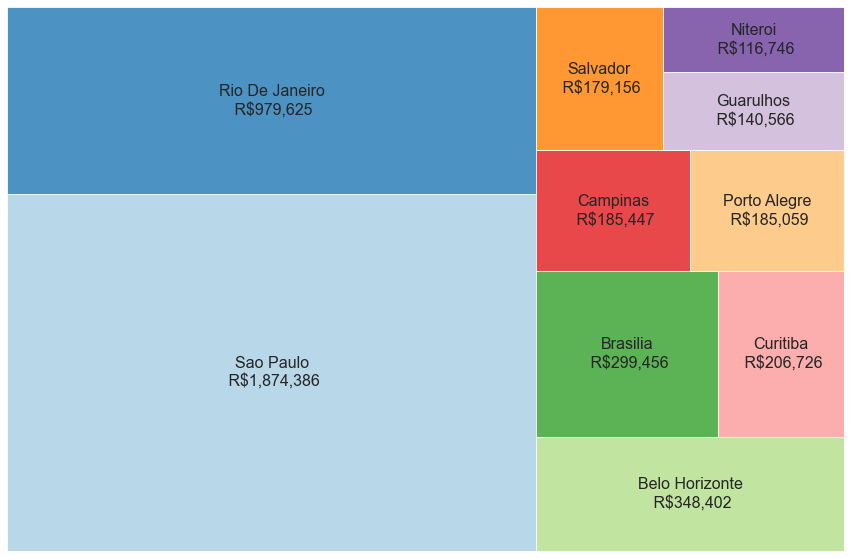

In [57]:
# create treemap to compare revenues across the top 10 cities
fig = plt.subplots(figsize = (15, 10))

labels = ['Sao Paulo\n R$1,874,386', 'Rio De Janeiro\n R$979,625',
          'Belo Horizonte\n R$348,402', 'Brasilia\n R$299,456',
          'Curitiba\n R$206,726', 'Campinas\n R$185,447',
          'Porto Alegre\n R$185,059', 'Salvador\n R$179,156',
          'Guarulhos\n R$140,566', 'Niteroi\n R$116,746']

ax6 = squarify.plot(sizes = revenue_city10['total_revenue'], label = labels,
                    color = sns.color_palette('Paired'), alpha = 0.8, 
                    text_kwargs={'fontsize':16} )
plt.axis('off')
plt.show();

### 3.4 Month-over-month Revenue Share from the Top 10 Cities

<ul>
    <li><p>Among the major cities, Sao Paulo showed significant revenue growth, from R\$15,395 in January 2017 to R\$156,247 in August 2018 (approximately a 10-fold increase over 20-month period), and represents a major source of continuous growth for the platform.</p></li>
    <br>
    <li><p>On the other hand, Rio de Janeiro's monthly revenue peaked in November 2017 at R\$83,591, and steadily maintained monthly revenue between R\$51,512 and R\$69379 in 2018. Although Rio de Janeiro is the second largest revenue contributor, it is not a reliable source of growth compared to Sao Paulo.</p></li>
    <br>
    <li><p>Other metro areas such as Belo Horizonte, Brasilia and Curitiba also maintained steady revenue stream in 2018 without sustaining notable continuous growth.</p></li>
</ul>

In [58]:
# filter order records from the top 10 cities
order10 = df_consolidated[df_consolidated['customer_city'].isin(city10_list)].reset_index(drop=True)

# sort orders by customer unique id and purchase date in ascending order
order10 = order10.sort_values(by = ['customer_unique_id', 'order_purchase_date'],
                              ascending = [True, True])

# subset the records from January 1st 2017 to Sept 1st 2018
order10 = order10[(order10['order_purchase_date'] >= startdate) & 
                  (order10['order_purchase_date'] <= enddate)].reset_index(drop=True)

In [59]:
# rename column
order10 = order10.rename({'customer_city': 'City'}, axis=1)

# change customer city to category type
order10['City'] = order10['City'].astype('category')
order10['City'] = order10['City'].cat.reorder_categories(['Sao Paulo','Rio De Janeiro','Belo Horizonte',
                                                          'Brasilia','Curitiba','Campinas','Porto Alegre',
                                                          'Salvador','Guarulhos','Niteroi'])


# create a pivot table by summing the revenue of each city by purchase month/year
order10_pivot = pd.pivot_table(order10, index='purchase_month_year', columns='City', 
                               values='trnx_price', aggfunc='sum')

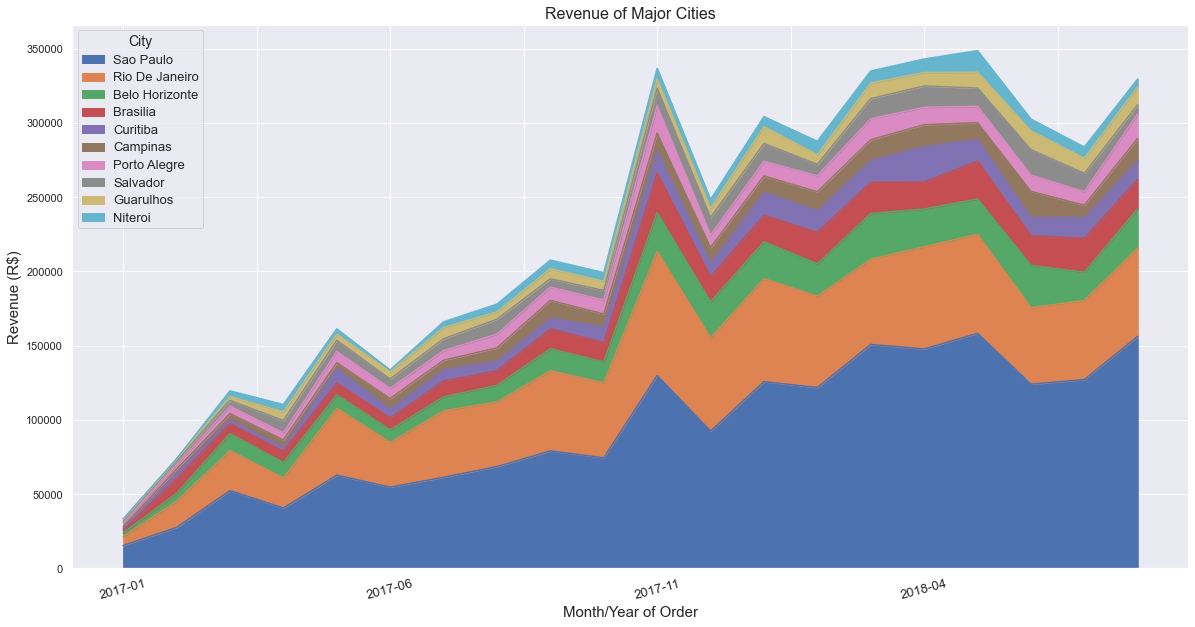

In [60]:
# create a custom stack bar
sns.set(rc={'figure.figsize':(20,10)})
stackb1 = order10_pivot.plot.area(stacked=True)
stackb1.axes.set_title("Revenue of Major Cities",fontsize=16)
stackb1.set_xlabel("Month/Year of Order",fontsize=15)
stackb1.set_ylabel("Revenue (R$)",fontsize=15)
stackb1.set_xticklabels(stackb1.get_xmajorticklabels(), fontsize = 13)
plt.setp(stackb1.get_legend().get_title(), fontsize='14')
plt.setp(stackb1.get_legend().get_texts(), fontsize='13')
plt.xticks(rotation=15)
plt.show();

### 3.5 Month-over-month Share of First-time Customers from the Top 10 Cities

In [61]:
# keep customers from the top 10 cities by their first order purchase date
cust_new = order10.drop_duplicates(subset=['customer_unique_id'], keep='first').reset_index(drop=True)

# create a pivot table by counting the number of unique customers from each city by purchase month/year
cust10_pivot = pd.pivot_table(order10, index='purchase_month_year', columns='City', 
                               values='customer_unique_id', aggfunc='count')

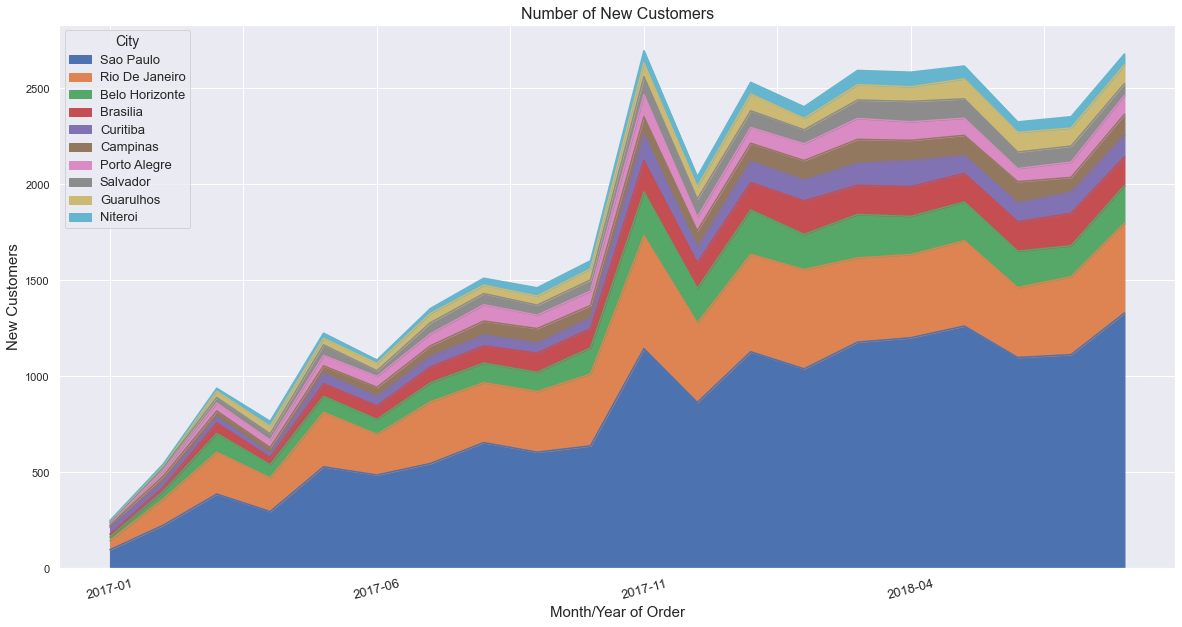

In [62]:
# create a custom stack bar
sns.set(rc={'figure.figsize':(20,10)})
stackb2 = cust10_pivot.plot.area(stacked=True)
stackb2.axes.set_title("Number of New Customers",fontsize=16)
stackb2.set_xlabel("Month/Year of Order",fontsize=15)
stackb2.set_ylabel("New Customers",fontsize=15)
stackb2.set_xticklabels(stackb2.get_xmajorticklabels(), fontsize = 13)
plt.setp(stackb2.get_legend().get_title(), fontsize='14')
plt.setp(stackb2.get_legend().get_texts(), fontsize='13')
plt.xticks(rotation=15)
plt.show();

### 3.6 Top Product Categories by Total Revenue

<ul>
    <li><p>17 of 74 product categories (23%) contributed to 80% of the platform's total revenue ie. a long tail distribution.</p></li>
    <br>
    <li><p>The top 10 product categories by total revenue are: Health/Beauty, Watches/Gifts, Bed/Bath/Table, Sports/Leisure, Computers Accessories, Furniture/Decor, Housewares, Cool Stuff, Auto, and Garden Tools. Collectively, the E-Commerce platform earned R\$8.35 million from these 10 product categories, or 62.5% of its total revenue.</p></li>
    <br>
    <li><p>Although majority of the transactions involved single item purchase, product categroies such as Health/Beauty, Bed/Bath/Table, Sports/Leisure, Computer Accessories and Furniture Decor also had transactions involving multiple units of the same item. Conducting market basket analysis may reveal insights of what products can be purchased together.</p></li>
    <br>
    <li><p>The platform could also use simple heuristics based on product metadata to start recommending similar products to customers, instead of launching collaborative filtering recommender model which requires extensive historical user events data. This may in turn boost the share of transactions of multiple items for further revenue growth.</p></li>
</ul>

In [63]:
# aggregate total revenue for each city
revenue_prod = df_consolidated.groupby(['product_category_name_english'])['trnx_price'].sum()\
                     .sort_values(ascending=False).reset_index()

# rename column
revenue_prod = revenue_prod.rename({'trnx_price': 'total_revenue'}, axis=1)

# create a cumulative % column
revenue_prod['cum_pct'] = (revenue_prod['total_revenue'].cumsum()/revenue_prod['total_revenue'].sum()) * 100

In [64]:
# select product categories that contributed to 80% of the total revenue
prod_cumsum80 = revenue_prod[(revenue_prod['cum_pct'] <= 80.0)]
prod80_count = prod_cumsum80['product_category_name_english'].count()

# count number of unique product categories
prod_count = df_consolidated['product_category_name_english'].nunique()

# % of 80th percentile cities 
pct_prod80 = prod80_count/prod_count * 100

print('Number of product categories that contributed to 80% of the total revenue: {}'.format(prod80_count))
print('Total number of product categories: {}'.format(prod_count))
print('% of 80th percentile product categories: {:.1f}%'.format(pct_prod80))

Number of product categories that contributed to 80% of the total revenue: 17
Total number of product categories: 74
% of 80th percentile product categories: 23.0%


In [65]:
# top 10 product categories by the total revenue
revenue_prod10 = revenue_prod.head(10).reset_index(drop=True)

# sum of total revenue by the top 10 product categories
prod10_rev = revenue_prod10['total_revenue'].sum()
# % revenue contribution by the top 10 cities
pct_prod10_rev = prod10_rev/total_rev * 100

print('Total revenue by the top 10 product categories: {:.0f}'.format(prod10_rev))
print('% revenue contribution by the top 10 product categories: {:.1f}%'.format(pct_prod10_rev))

Total revenue by the top 10 product categories: 8353397
% revenue contribution by the top 10 product categories: 62.5%


In [66]:
# store the top 17 product categories in a list
prod17_list = list(prod_cumsum80['product_category_name_english'].values)

# get orders that contained from the top 10 cities
prod17 = df_consolidated[df_consolidated['product_category_name_english'].isin(prod17_list)].reset_index(drop=True)

# rename column
prod17 = prod17.rename({'product_category_name_english': 'Product Category'}, axis=1)

In [67]:
# function to categorize item quantity by range
def iqty(row):
    if (row['item_qty'] == 1):
        return '1'
    elif (row['item_qty'] == 2):
        return '2'
    elif (row['item_qty'] == 3):
        return '3'
    else:
        return '>= 4'
    
prod17['Item Quantity'] = prod17.apply(lambda row: iqty(row), axis=1)

In [68]:
# change to category type
prod17['Product Category'] = prod17['Product Category'].astype('category')
prod17['Product Category'] = prod17['Product Category'].cat.reorder_categories(['Health Beauty','Watches Gifts',
                                                                                'Bed Bath Table','Sports Leisure',
                                                                                'Computers Accessories',
                                                                                'Furniture Decor','Housewares',
                                                                                'Cool Stuff','Auto','Garden Tools',
                                                                                'Toys','Baby','Perfumery',
                                                                                'Telephony','Office Furniture',
                                                                                'Stationery','Computers'])

prod17['Item Quantity'] = prod17['Item Quantity'].astype('category')
prod17['Item Quantity'] = prod17['Item Quantity'].cat.reorder_categories(['1','2','3','>= 4'])

# transaction price in R$1000s
prod17['trnx_price'] = prod17['trnx_price'] / 1000

# create a pivot table by summing the revenue of each city by purchase month/year
prod17_pivot = pd.pivot_table(prod17, index='Product Category', columns='Item Quantity',
                              values='trnx_price', aggfunc='sum')

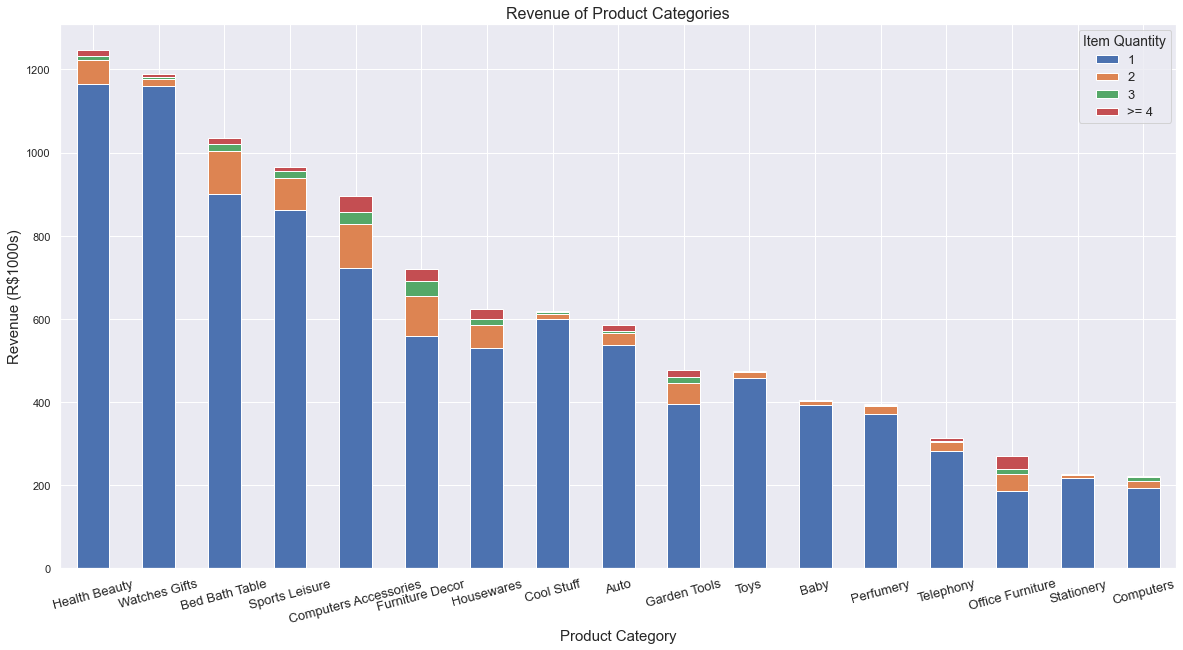

In [69]:
# create a custom stack bar
sns.set(rc={'figure.figsize':(20,10)})
stackb3 = prod17_pivot.plot.bar(stacked=True)
stackb3.axes.set_title("Revenue of Product Categories",fontsize=16)
stackb3.set_xlabel("Product Category",fontsize=15)
stackb3.set_ylabel("Revenue (R$1000s)",fontsize=15)
stackb3.set_xticklabels(stackb3.get_xmajorticklabels(), fontsize = 13)
plt.setp(stackb3.get_legend().get_title(), fontsize='14')
plt.setp(stackb3.get_legend().get_texts(), fontsize='13')
plt.xticks(rotation=15)
plt.show();

### 3.7 Month-over-month Revenue Share from the Top 10 Product Categories

<ul>
    <li><p>Health and Beauty products showed consistent growth, from R\$12,421 in January 2017 to R\$120,320 in August 2018. This category sustained double digits revenue growth in 2018, and it is the most promising source of revenue for the platform.</p></li>
    <br>
    <li><p>Watches and Gifts has a peak monthly revenue in March 2018 at R\$121,849. However, the category was unable to maintain consecutive month-over-month growth in 2018. Perhaps some seasonality contributed to the fluctuation.</p></li>
    <br>
    <li><p>Although Bed/Bath/Table maintained steady revenue stream without attaining notable growth in 2018, other categories such as Sports/Leisure, Computers Accessories, and Cool Stuff suffered from multiple months of revenue decline. On the other hand, Housewares and Auto maintained small but steady growth through 2018.</p></li>
</ul>

In [70]:
# store the top 10 product categories in a list
prod10_list = list(revenue_prod10['product_category_name_english'].values)

# get orders that contained from the top 10 product categories
prod10 = df_consolidated[df_consolidated['product_category_name_english'].isin(prod10_list)].reset_index(drop=True)

# rename column
prod10 = prod10.rename({'product_category_name_english': 'Product Category'}, axis=1)

# subset the records from January 1st 2017 to Sept 1st 2018
prod10 = prod10[(prod10['order_purchase_date'] >= startdate) & 
                (prod10['order_purchase_date'] <= enddate)].reset_index(drop=True)

In [71]:
# change to category type
prod10['Product Category'] = prod10['Product Category'].astype('category')
prod10['Product Category'] = prod10['Product Category'].cat.reorder_categories(['Health Beauty','Watches Gifts',
                                                                                'Bed Bath Table','Sports Leisure',
                                                                                'Computers Accessories',
                                                                                'Furniture Decor','Housewares',
                                                                                'Cool Stuff','Auto','Garden Tools'])

# create a pivot table by summing the revenue of each city by purchase month/year
prod10_pivot = pd.pivot_table(prod10, index='purchase_month_year', columns='Product Category', 
                              values='trnx_price', aggfunc='sum')

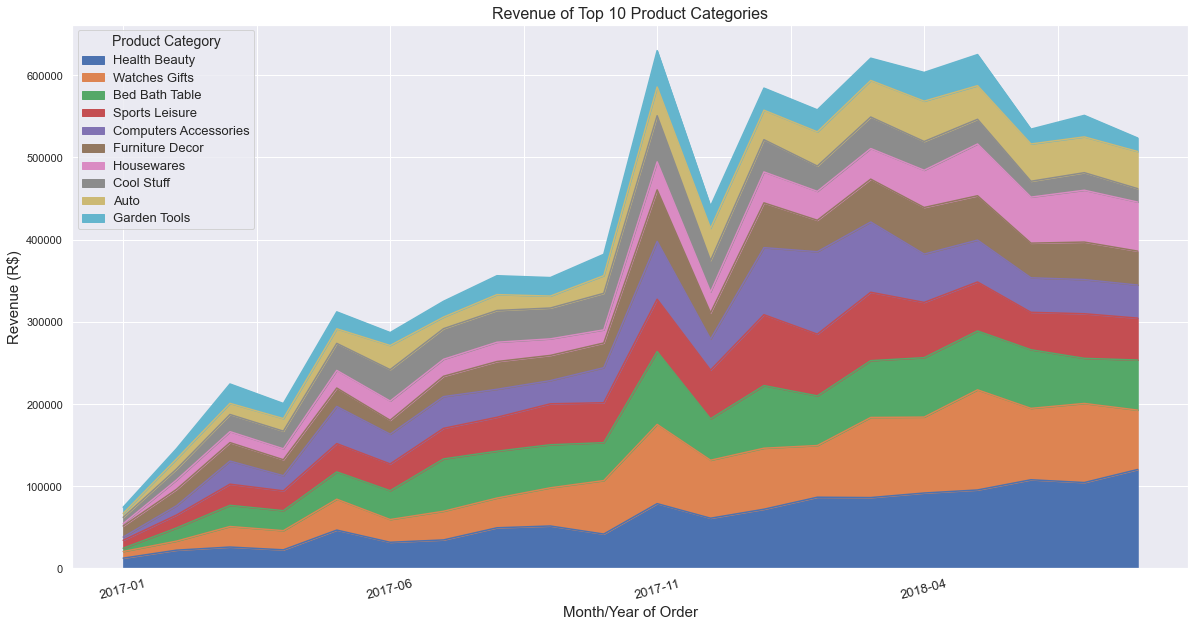

In [72]:
# create a custom stack bar
sns.set(rc={'figure.figsize':(20,10)})
stackb4 = prod10_pivot.plot.area(stacked=True)
stackb4.axes.set_title("Revenue of Top 10 Product Categories",fontsize=16)
stackb4.set_xlabel("Month/Year of Order",fontsize=15)
stackb4.set_ylabel("Revenue (R$)",fontsize=15)
stackb4.set_xticklabels(stackb4.get_xmajorticklabels(), fontsize = 13)
plt.setp(stackb4.get_legend().get_title(), fontsize='14')
plt.setp(stackb4.get_legend().get_texts(), fontsize='13')
plt.xticks(rotation=15)
plt.show();

## 4. Customer Segmentation

### RFM Analysis

- Recency: Number of days since the last transaction with the platform
- Frequency: Total number of transactions, average number of days between each transaction
- Monetary: Total transaction values, average transaction values
    
Basic assumptions of RFM:
    
- The more recent the transaction, the more responsive the customer is to promotions
- The more frequently the customer conducts a transaction, the more engaged and satisfied they are with the platform
- Monetary value of the transactions differentiate heavy spenders from low-value customers

Frequency and average transaction values (or min/max transaction values) are not appropriate for this dataset since 96.6% of the customers are non-repeating consumers, and these features are not informative for single purchase transactions. 

**Note**: I created additional features by summing the total transaction values that each customer spent on the individual product category in order to distinguish their shopping interest. However, this resulted in a sparse dataset where most customers purchased items from only 1 product category, causing the segmentation to suggest 18 or more clusters. Instead, shopping interests will be appended at the end after the segmentation is completed.

In [73]:
df_rfm = df_consolidated[['customer_unique_id','customer_city','customer_state',
                          'order_id','order_purchase_date','item_qty','trnx_price']]

# aggregate item_qty and trnx_price by customer_unique_id and order_id
df_sum = df_rfm.groupby(['customer_unique_id','customer_city','customer_state',
                          'order_id','order_purchase_date'])['item_qty','trnx_price'].sum().reset_index()

df_sum = df_sum.sort_values(by = ['customer_unique_id', 'order_purchase_date'], 
                            ascending = [True, True]).reset_index(drop=True)

<ipython-input-73-12700ab8bb7f>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sum = df_rfm.groupby(['customer_unique_id','customer_city','customer_state',


### 4.1 Recency
- Timelapse (number of days) since last transaction = final transaction timestamp in the dataset - last transaction for each customer ID

In [74]:
# get last transaction date
final = df_sum['order_purchase_date']
final = final.reset_index(name='order_purchase_date')
final = final.sort_values(by=['order_purchase_date'], ascending=False).reset_index(drop=True)

# assign timebound as +1 days since the last transaction 
last = final['order_purchase_date'].iloc[0] + timedelta(days=1)

print(last)

2018-09-04


In [75]:
# get the lapse days for each customer ID
df_sum['last_date'] = last
df_sum['lapse_days'] = (df_sum['last_date'] - df_sum['order_purchase_date']).dt.days

# keep the last purchase record and the lapse day
lastlapse = df_sum[['customer_unique_id','order_purchase_date','lapse_days']]
lastlapse = lastlapse.sort_values(by=['order_purchase_date'], ascending=True).reset_index(drop=True)
lastlapse = lastlapse.drop_duplicates('customer_unique_id', keep='last').reset_index(drop=True)
lastlapse = lastlapse[['customer_unique_id','lapse_days']] 

### 4.2 Monetary
- Total transaction value = sum of transaction amounts by customer id

In [76]:
trnxtot = df_sum.groupby(['customer_unique_id'])['trnx_price'].sum().reset_index()

In [77]:
df_cust = df_sum[['customer_unique_id']]
df_cust = df_cust.drop_duplicates().reset_index(drop=True)

df_cust = pd.merge(df_cust, lastlapse, how='inner',on=['customer_unique_id']) \
            .merge(trnxtot, how='inner',on=['customer_unique_id'])

df_cust = df_cust[['customer_unique_id','trnx_price','lapse_days']]

# rename columns
df_cust = df_cust.rename({'trnx_price': 'Transaction Value',
                          'lapse_days': 'Recency'}, axis=1)

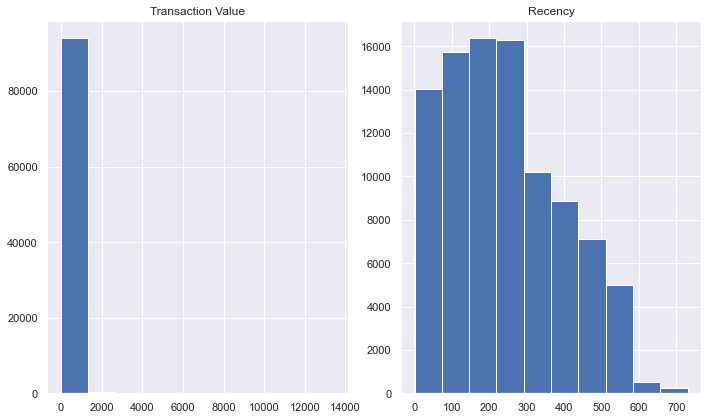

In [78]:
# visualize distribution of each feature
df_cust.hist(figsize=(10,6))
plt.tight_layout();

- Perform log-transform on transaction value because the feature is positively skewed.

In [79]:
df_cust['Transaction Value'] = np.log(df_cust['Transaction Value'])

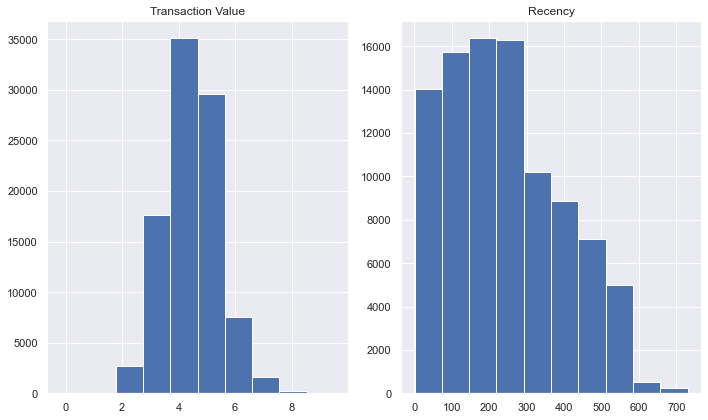

In [80]:
df_cust.hist(figsize=(10,6))
plt.tight_layout();

In [81]:
# create dataframe for kmeans feature 
kfeat = df_cust.copy()

# drop customer unique id since it only uses numerical variables
kfeat = kfeat.drop(columns=['customer_unique_id'])

In [82]:
# scale the features
scaler = StandardScaler()
feat_scaled = scaler.fit_transform(kfeat)

# convert to data frame and check summary stats
feat_scaled = pd.DataFrame(feat_scaled, index= kfeat.index, columns = kfeat.columns)
feat_scaled.describe()

,Transaction Value,Recency
count,9.439800e+04,9.439800e+04
mean,3.933689e-16,2.175801e-18
std,1.000005e+00,1.000005e+00
min,-4.937591e+00,-1.589613e+00
25%,-6.439523e-01,-8.103922e-01
50%,2.932781e-02,-1.228442e-01
75%,6.117443e-01,7.087614e-01
max,5.369945e+00,3.183934e+00


### 4.3 Elbow method

<ul>
    <li><p>Elbow method is a quick heuristic approach that calculates the average distance of each point in a cluster to its centroid, and we typically select the k value at the elbow point where the decline in SSE begins to level off.</p></li>
    <br>
    <li><p>The Elbow plot suggests the optimal number of clusters is 3.</p></li>
</ul>

In [83]:
# calculate the SSE for eack k between 1 and 8
sse = {}
for k in range(1,9):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(feat_scaled)
    sse[k] = kmeans.inertia_

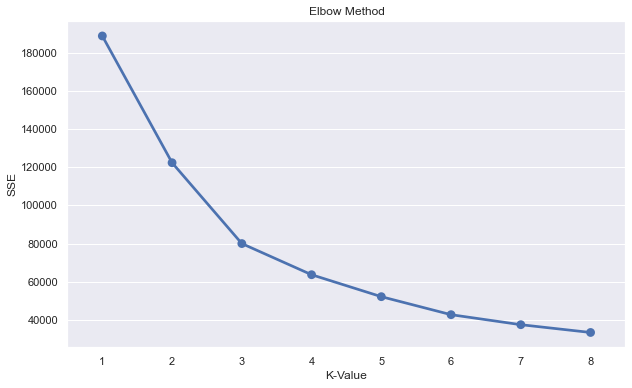

In [84]:
# plot the SSE for each k between 1 and 8
fig = plt.subplots(figsize = (10, 6))
sns.pointplot(x = list(sse.keys()), y = list(sse.values()))

plt.title('Elbow Method')
plt.xlabel('K-Value')
plt.ylabel('SSE')
plt.show();

### 4.4 Silhouette Analysis

<ul>
    <li><p>Silhouette analysis is a more robust approach that computes the average distance of all points within the same cluster, and the average distance of each point to the points in the nearest neighboring cluster.</p></li>
    <br>
    <li><p>We typically select the optimal k value that has the highest average Silhouette score, where every cluster is above the average Silhouette score, and the points are evenly distributed into each cluster in the Silhouette plot.</p></li>
    <br>
    <li><p>Silhouette analysis also indicates the optimal number of clusters is 3. Although k value of 6 is an alternative number of clusters, notice that the points are not as evenly distributed into each cluster (eg. cluster 2, 3 and 4 are smaller clusters with the presence of outliers).</p></li>
</ul>
</ul>

### Note:  Bottleneck step

For n_clusters = 2 The average silhouette_score is : 0.3453711488759771
For n_clusters = 3 The average silhouette_score is : 0.35740235979333623
For n_clusters = 4 The average silhouette_score is : 0.33333483985743806
For n_clusters = 5 The average silhouette_score is : 0.33030715187650955
For n_clusters = 6 The average silhouette_score is : 0.3471236190444584
For n_clusters = 7 The average silhouette_score is : 0.3380438448399201
For n_clusters = 8 The average silhouette_score is : 0.33779432063210585


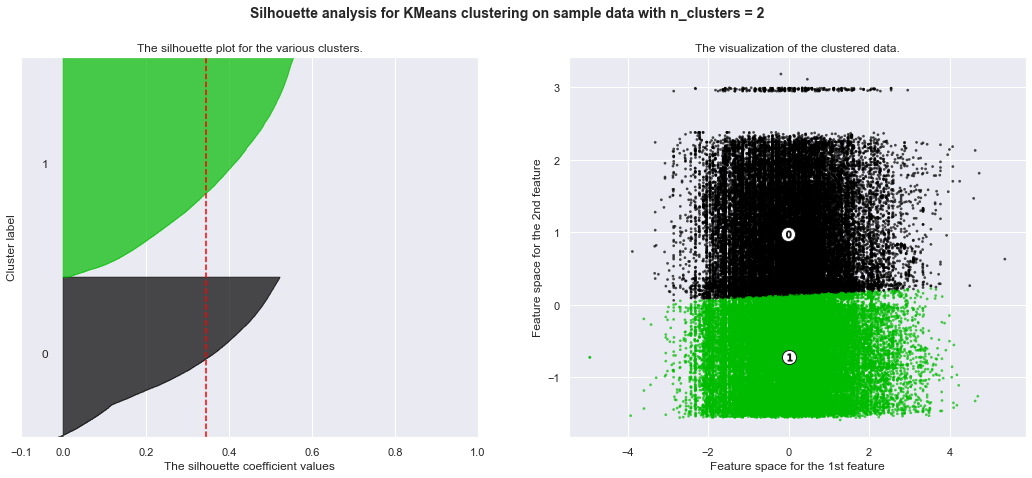

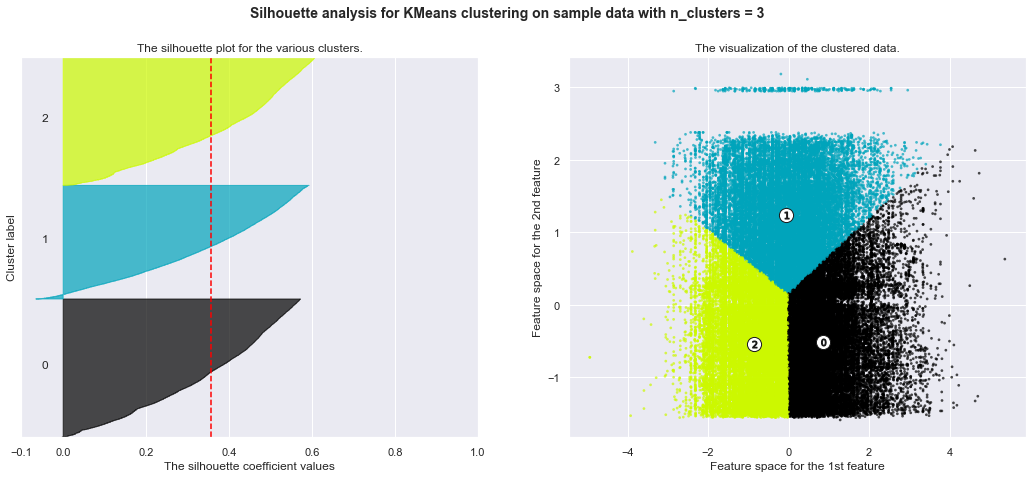

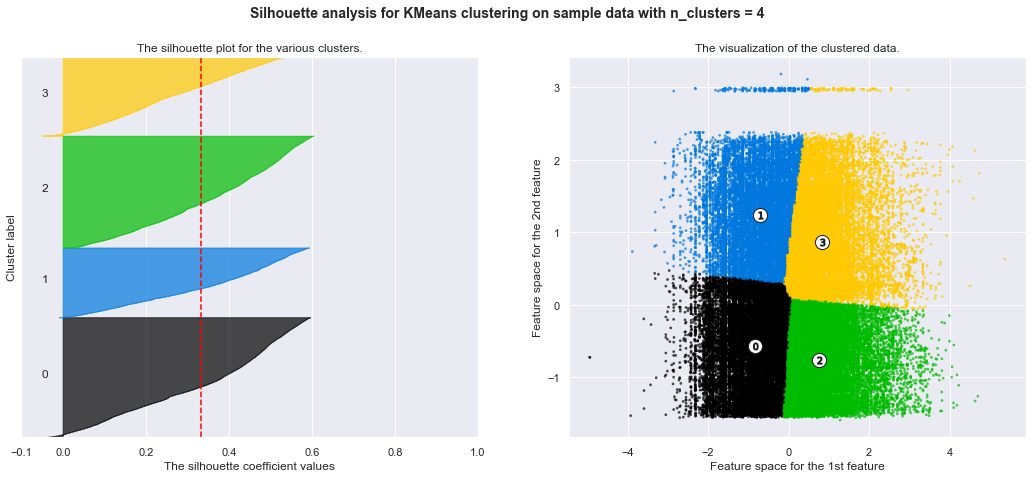

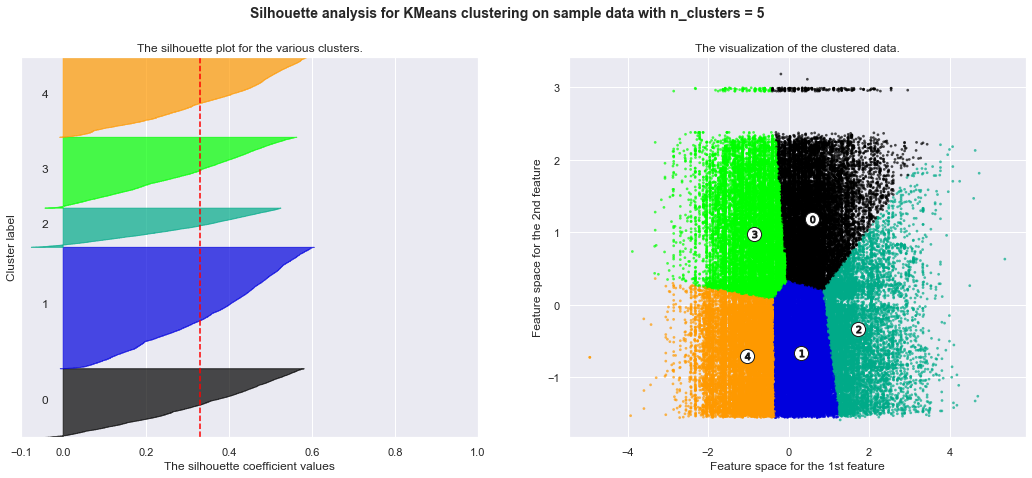

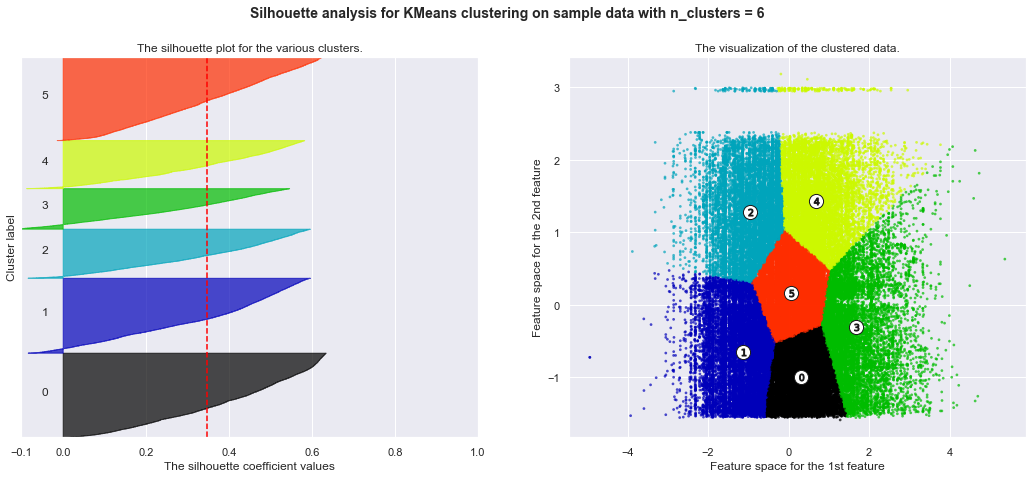

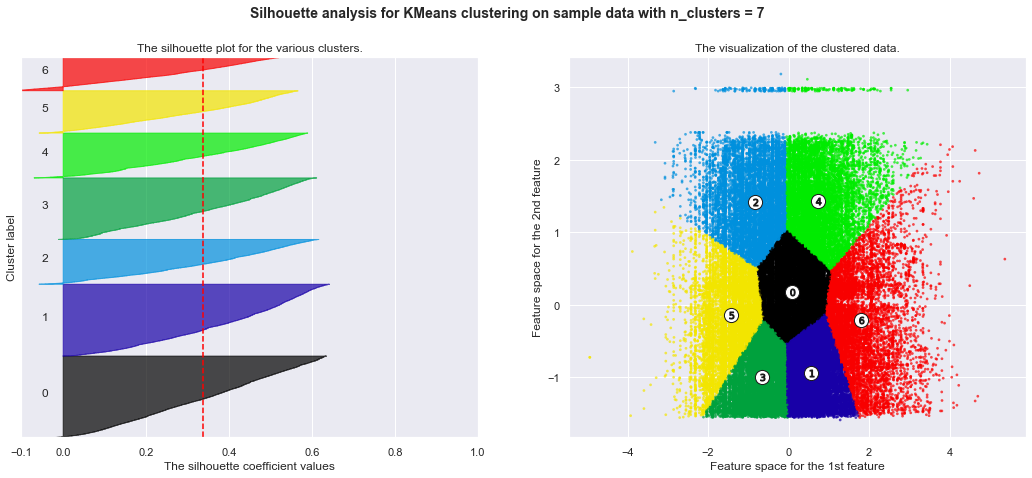

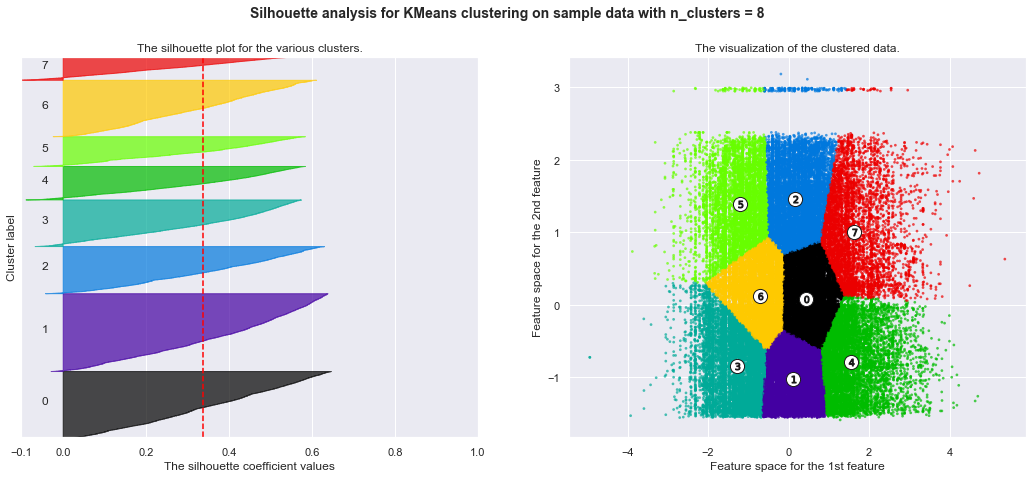

In [85]:
# calculate the average silhouette score for each k between 2 and 8
silhoutte_analysis(feat_scaled.values, list(range(2,9)))

### 4.5 K-Means Segmentation

<ul>
    <li><p>Perform K-Means segmentation and assign each customer to their cluster.</p></li>
    <br>
    <li><p>Then create a pivot table to sum the total transaction values that each customer spent on the product categories. Since the top 17 product categories contributed 80% of the platform revenue, the rest will be re-labled as Others.</p></li>
</ul>

In [86]:
# apply k-means with k = 3
kcust = KMeans(n_clusters=3)
kcust.fit(feat_scaled)
cust_labels = kcust.labels_

In [87]:
# assign cluster number to each customer unique ID
df_cust = df_cust.assign(Cluster=cust_labels)

# inverse log transformation on transaction value
df_cust['Transaction Value'] = np.exp(df_cust['Transaction Value'])

In [88]:
# create a pivot table to identify each cluster's primary shopping interest
df_inst = df_consolidated[['customer_unique_id','product_category_name_english','trnx_price']]

# change product category names to 'Others' if they are not in prod17_list
df_inst.loc[~df_inst['product_category_name_english'].isin(prod17_list), 'product_category_name_english'] = 'Others'

# create dataframe from pivot table by summing the price spent 
# on each product category by customer unique id
inst_pivot = pd.pivot_table(df_inst, index='customer_unique_id', columns='product_category_name_english',
                            values='trnx_price', aggfunc='sum').reset_index()

# replace all NaN with 0.0 
inst_pivot = inst_pivot.fillna(0.0).reset_index(drop=True)

/Users/shayneli/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [89]:
df_cust = pd.merge(df_cust, inst_pivot, how='inner',on=['customer_unique_id'])

In [90]:
df_cust.head(5)

,customer_unique_id,Transaction Value,Recency,Cluster,Auto,Baby,Bed Bath Table,Computers,Computers Accessories,Cool Stuff,...,Health Beauty,Housewares,Office Furniture,Others,Perfumery,Sports Leisure,Stationery,Telephony,Toys,Watches Gifts
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,117,2,0.0,0.0,129.9,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,120,1,0.0,0.0,0.0,0.0,0.0,0.0,...,18.9,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0000f46a3911fa3c0805444483337064,69.00,543,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,69.0,0.00,0.0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,327,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.99,0.0,0.0
4,0004aac84e0df4da2b147fca70cf8255,180.00,294,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.00,0.0,0.0


In [108]:
# apply aggregate function for each cluster
df_segment = df_cust.groupby('Cluster').agg({'Transaction Value': [('Mean Transaction Value', 'mean')], 
                                             'Recency': [('Mean Recency', 'mean')],
                                             'Auto': [('Auto', 'sum')], 
                                             'Baby': [('Baby', 'sum')],
                                             'Bed Bath Table': [('Bed Bath Table', 'sum')], 
                                             'Computers': [('Computers', 'sum')],
                                             'Computers Accessories': [('Computers Accessories', 'sum')], 
                                             'Cool Stuff': [('Cool Stuff', 'sum')],
                                             'Furniture Decor': [('Furniture Decor', 'sum')], 
                                             'Garden Tools': [('Garden Tools', 'sum')],
                                             'Health Beauty': [('Health Beauty', 'sum')], 
                                             'Housewares': [('Housewares', 'sum')],
                                             'Office Furniture': [('Office Furniture', 'sum')], 
                                             'Perfumery': [('Perfumery', 'sum')],
                                             'Sports Leisure': [('Sports Leisure', 'sum')], 
                                             'Stationery': [('Stationery', 'sum')],
                                             'Telephony': [('Telephony', 'sum')], 
                                             'Toys': [('Toys', 'sum')],
                                             'Watches Gifts': [('Watches Gifts', 'sum')], 
                                             'Others': [('Others', 'sum')],
                                             'customer_unique_id': [('Customer Count', 'nunique')]}).reset_index()

# Drop multi-index for columns and remove unnamed column
df_segment.columns = df_segment.columns.droplevel()
df_segment = df_segment.drop(df_segment.columns[0], axis=1)

In [109]:
df_segment

,Mean Transaction Value,Mean Recency,Auto,Baby,Bed Bath Table,Computers,Computers Accessories,Cool Stuff,Furniture Decor,Garden Tools,...,Housewares,Office Furniture,Perfumery,Sports Leisure,Stationery,Telephony,Toys,Watches Gifts,Others,Customer Count
0,112.460687,432.365696,107034.40,78352.46,326791.33,2199.99,175222.20,201518.63,207500.01,158147.66,...,146433.84,79565.09,144803.80,249420.54,51413.16,66534.09,158666.33,183495.79,569107.47,28078
1,44.583213,161.159150,59719.32,41993.80,153165.59,34.50,103693.77,22531.08,93179.34,50811.43,...,95606.18,4326.17,40860.81,102403.64,40451.47,72933.84,49533.81,53402.19,293691.35,31819
2,254.948005,166.447436,417398.05,285195.62,554211.19,219078.65,617704.54,394258.44,418406.16,266571.19,...,381751.97,186296.77,207855.18,614604.69,134676.14,173745.44,265745.87,952147.09,1851767.18,34501


We have 3 main customer segments based on the K-Means segmentaion performed above:
<ul>
    <li><p>Cluster 1: These are customers who have likely churned from the E-Commerce platform, because it was more than a year since their last transaction. These customers have moderate transaction values and spent an average of R\$112 on their purchase, on product categories such as Bed/Bath/Table, Health/Beauty, and Sports/Leisure.</p></li>
    <br>
    <li><p>Cluster 2: These are customers who made casual purchases on the E-Commerce platform. These customers have moderate recency but low transaction values as they spent an average of R\$44 on their purchase, on product categories such as Bed/Bath/Table, Health/Beauty, and Computer Accessories. The goal is to encourage them to spend more on the platform, perhaps with sales and promotions, and convert them into loyal customers.</p></li>
    <br>
    <li><p>Cluster 3: These are potentially loyal customers with high transaction values and moderate recency within the past 5 months. These customers spent an average of R\$255 on their purchase, on product categories such as Watches/Gifts, Health/Beauty, and Sports/Leisure. The goal is to incentivize them with continued spending through loyalty programs and point rewards.</p></li>
</ul>


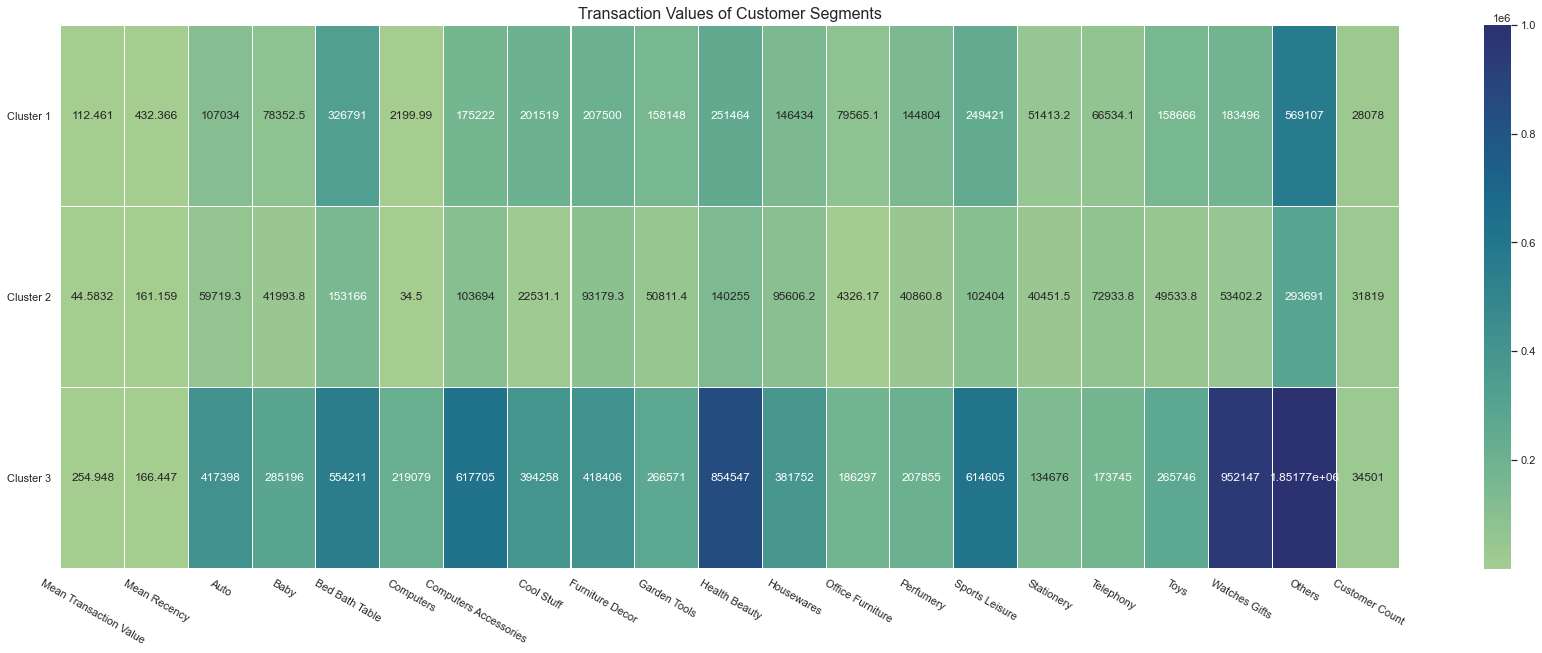

In [115]:
# plot the transaction values of each cluster
fig = plt.subplots(figsize = (30, 10))
seg_plot = sns.heatmap(df_segment, annot=True, xticklabels=df_segment.columns,
                       yticklabels=['Cluster 1','Cluster 2','Cluster 3'], fmt='g',
                       cmap='crest', vmax=1000000.00, linewidths=0.1, linecolor='white')

seg_plot.axes.set_title('Transaction Values of Customer Segments',fontsize=16)
plt.xticks(rotation=-30)
plt.yticks(rotation=0)
plt.show();